# The Wine Quality Dataset - Outliers and Anomalies

### Library Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from venny4py.venny4py import *
import klib

from sklearn.preprocessing import StandardScaler
from scipy.stats import median_abs_deviation as mad 

from pyod.models.ecod import ECOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
color_1 = 'olivedrab'
color_2 = 'darkred'

In [3]:
# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Load Data
- https://archive.ics.uci.edu/dataset/186/wine+quality

In [4]:
red_df = pd.read_csv('winequality-red.csv', sep=';')
red_df['wine type'] = 'Red'

white_df = pd.read_csv('winequality-white.csv', sep=';')
white_df['wine type'] = 'White'

df = pd.concat([red_df, white_df])


In [5]:
df = df.reset_index(drop=True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,Red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,Red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,Red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,White
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,White
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,White
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,White


### Features

In [6]:
col_list = df.columns.tolist()
col_list = [c for c in col_list if c not in ['id', 'quality', 'wine type']]

### EDA

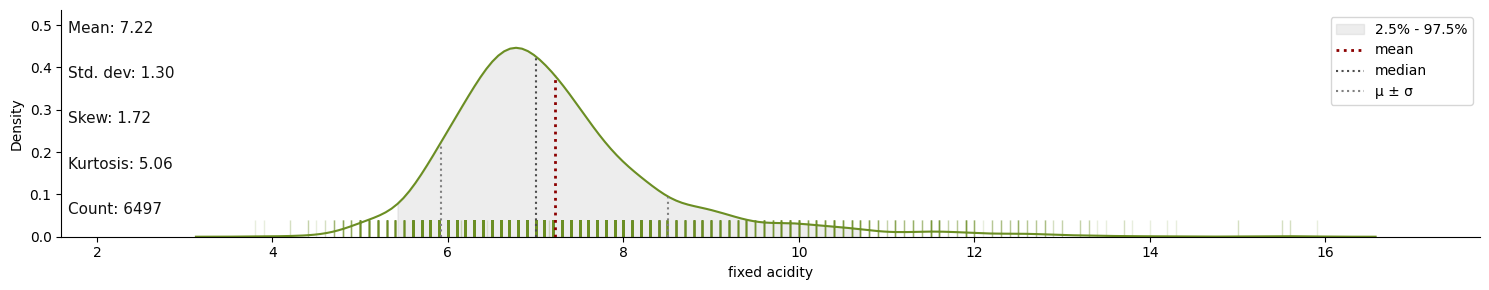

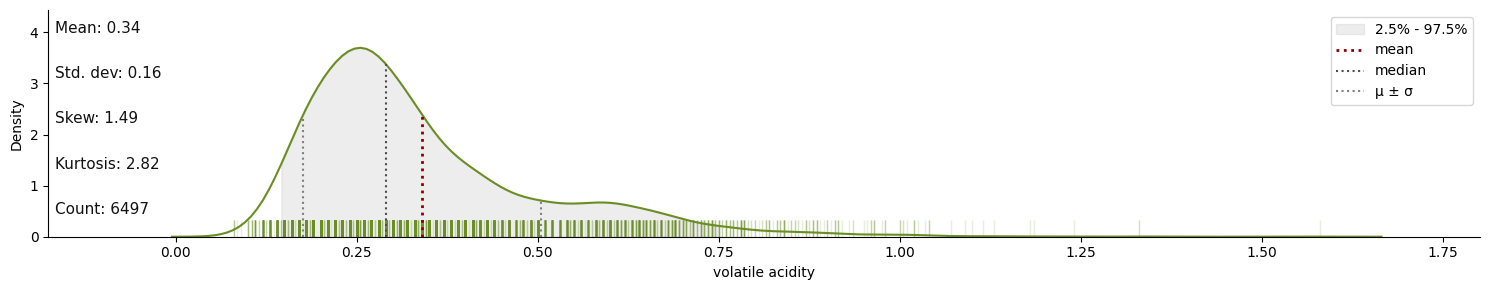

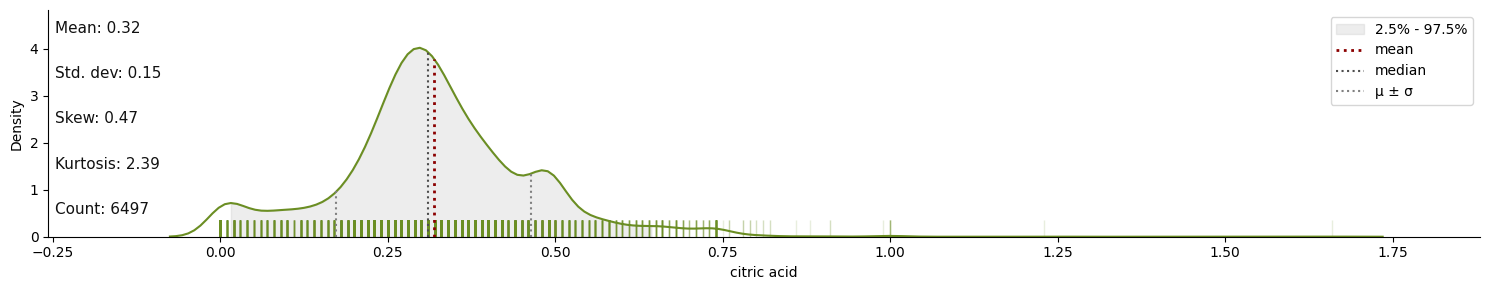

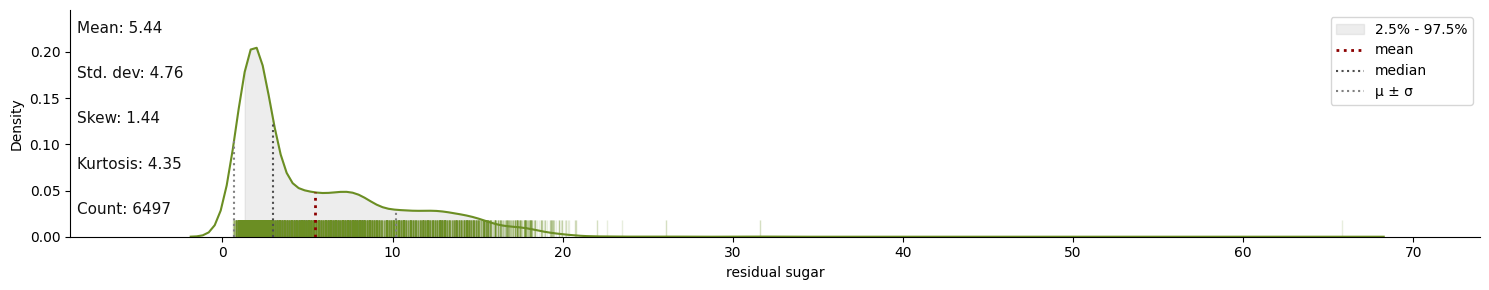

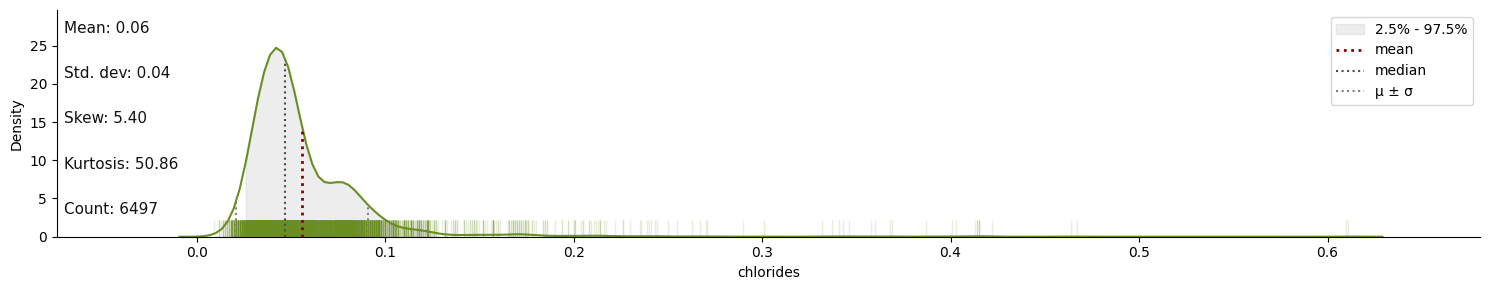

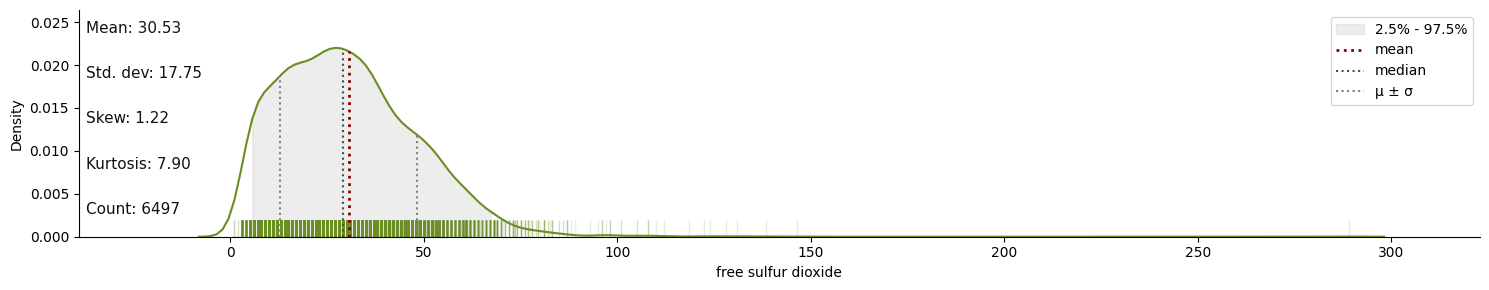

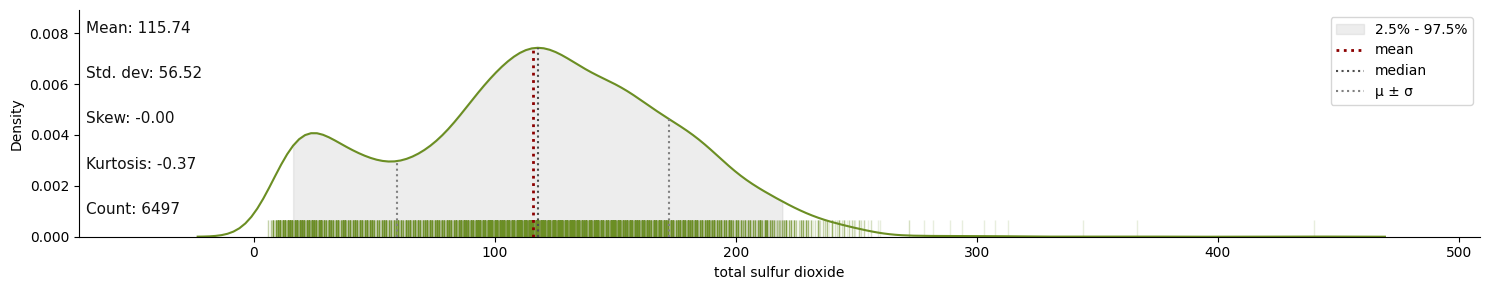

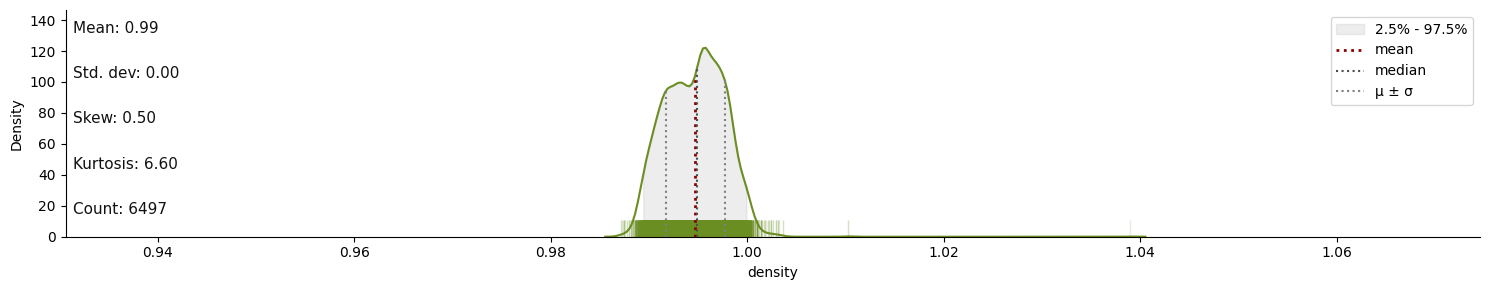

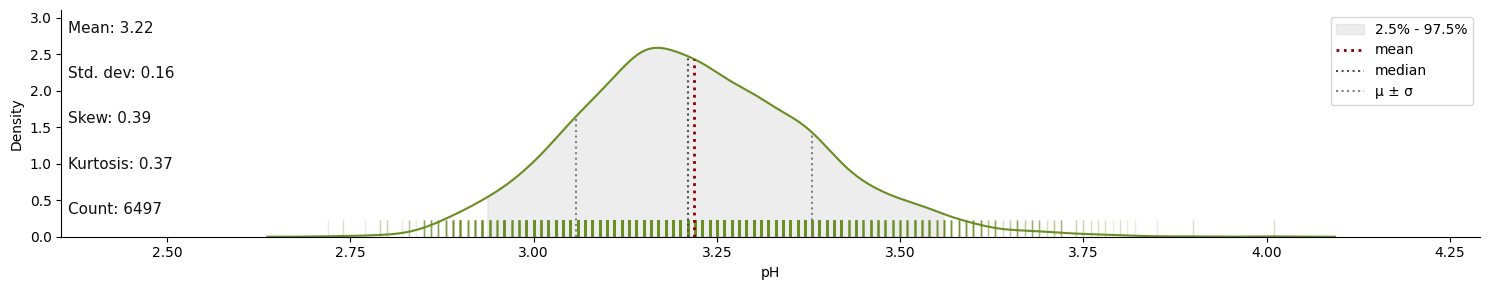

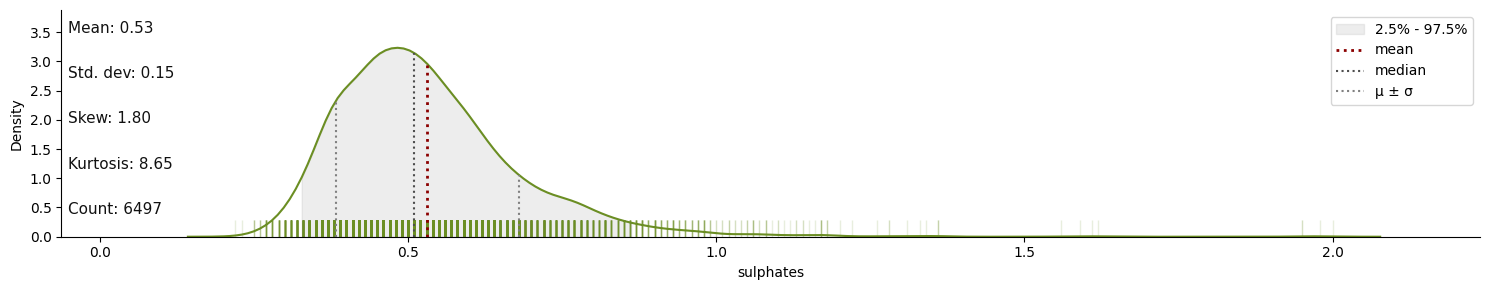

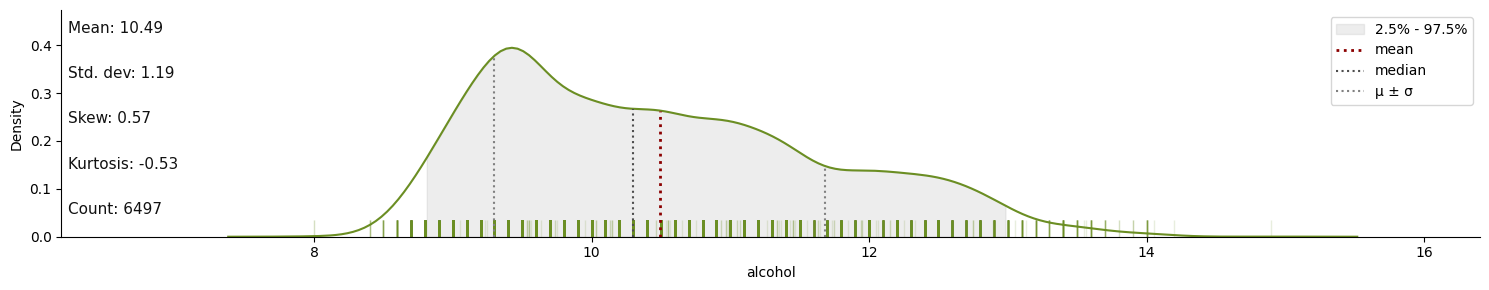

In [7]:
# Create distplot for all 
klib.dist_plot(df[col_list], showall=True, kde_kws = {'color': color_1}, 
                                        fill_kws = {'color': 'darkgrey', 'alpha': 0.2},
                                        rug_kws = {'color': color_2, 'alpha': 0.15, 'lw': 3, 'height': 0.075},
                                        mean_color = color_2
            )
plt.show()

### Impute Nulls

In [8]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine type               0
dtype: int64

In [9]:
df = df.fillna(0)

### Variables

In [10]:
# The number of +/- standard deviations away from the mean to be classified as a z-score outlier
std_threshold = 3
# The number of +/- "standard deviations" away from the median to to be classified as a modified z-score outlier
mod_std_threshold = 3.5
# If a datapoint is this many times greater than or less than the interquartile range (IQR) than it is classified as an outlier. 
iqr_threshold = 1.5

In [11]:
# Default pyod parameter, an estimate of the percentage of expected outliers
# Will use the probabilities instead of a threshold, but we need a value
contamination = 0.1

In [12]:
# Predicted probability to consider an anomaly
anomaly_prob_threshold = 0.8

In [13]:
# Set the voting threshold, at least this many votes
anomaly_voting_threshold = 1

### Scale

In [14]:
scaler = StandardScaler()
df[col_list] = scaler.fit_transform(df[col_list])

# Univariate Outliers
### Conditional Skew

In [ ]:
# Start with only Inliers
df['outlier_flag'] = 0

# Iterate through each column
for col in col_list:

    # Check skew of data
    skewness = df[col].skew()

    # Passing on low cardinality
    if df[col].nunique() > 2:

        # For Normal data use z-score
        if (abs(skewness) <= 0.5):
            mean_val = df[col].mean()
            std_val = df[col].std()
            z_score = (df[col] - mean_val) / std_val
            df['outlier_flag'] = np.where(abs(z_score) > std_threshold, 1, df['outlier_flag'])
            df[col + '_outlier'] = np.where(abs(z_score) > std_threshold, 1, 0)

        # For moderately skewed data use modified z-score
        elif (abs(skewness) > 0.5) & (abs(skewness) <= 1):
            median_val = df[col].median()
            mad_val = mad(df[col]) 
            mod_z_score = 0.6745 * (df[col] - median_val) / mad_val
            df['outlier_flag'] = np.where((abs(mod_z_score) > (mod_std_threshold)), 1, df['outlier_flag'])
            df[col + '_outlier'] = np.where((abs(mod_z_score) > (mod_std_threshold)), 1, 0)

        # For highly skewed data use IQR
        else:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            # If there is a suitable range use IQR for highly skewed
            if IQR > 0:
                df['outlier_flag'] = np.where(((df[col] < (Q1 - (iqr_threshold) * IQR)) | (df[col] > (Q3 + (iqr_threshold) * IQR))), 1, df['outlier_flag'])
                df[col + '_outlier'] = np.where(((df[col] < (Q1 - (iqr_threshold) * IQR)) | (df[col] > (Q3 + (iqr_threshold) * IQR))), 1, 0)

            # For extreme skew log transform then use modified z-score
            else:
                # Determine the shift value. If data contains 0 or negative values,
                # we need to shift it so that min_shifted_value >= 0 for np.log1p(x) (where x is >=0)
                min_value = df[col].min()
                shift = 0
                if min_value < 0:
                    shift = abs(min_value) # Shift to make the smallest value 0
                elif min_value == 0:
                    shift = 1 # Shift by 1 if min value is 0, so 0 becomes 1 for log
                # Apply np.log1p or log(x + 1) to the shifted data 
                log_transformed = np.log1p(df[col] + shift)
                median_val = log_transformed.median()
                mad_val = mad(log_transformed)
                mod_z_score = 0.6745 * (log_transformed - median_val) / mad_val
                df['outlier_flag'] = np.where(abs(mod_z_score) > (mod_std_threshold), 1, df['outlier_flag'])
                df[col + '_outlier'] = np.where(abs(mod_z_score) > (mod_std_threshold), 1, 0)


In [ ]:
# Total number of outlier metrics per record
df['total_outliers'] = df[[c for c in df.columns if c.endswith('_outlier')]].sum(axis=1)

In [ ]:
# Total outliers / number of metrics
df['outlier_score'] = df['total_outliers'] / len(col_list)

### Group By Conditional Ensemble

In [15]:
def conditional_outlier_ensemble(df, col_list, std_threshold = 3, mod_std_threshold = 3.5, iqr_threshold = 1.5):

    # Start with only Inliers
    df['outlier_flag'] = 0

    # Iterate through each column
    for col in col_list:

        # Check skew of data
        skewness = df[col].skew()

        # Passing on low cardinality
        if df[col].nunique() > 2:

            # For Normal data use z-score
            if (abs(skewness) <= 0.5):
                mean_val = df[col].mean()
                std_val = df[col].std()
                z_score = (df[col] - mean_val) / std_val
                df['outlier_flag'] = np.where(abs(z_score) > std_threshold, 1, df['outlier_flag'])
                df[col + '_outlier'] = np.where(abs(z_score) > std_threshold, 1, 0)

            # For moderately skewed data use modified z-score
            elif (abs(skewness) > 0.5) & (abs(skewness) <= 1):
                median_val = df[col].median()
                mad_val = mad(df[col]) 
                mod_z_score = 0.6745 * (df[col] - median_val) / mad_val
                df['outlier_flag'] = np.where((abs(mod_z_score) > (mod_std_threshold)), 1, df['outlier_flag'])
                df[col + '_outlier'] = np.where((abs(mod_z_score) > (mod_std_threshold)), 1, 0)

            # For highly skewed data use IQR
            else:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1

                # If there is a suitable range use IQR for highly skewed
                if IQR > 0:
                    df['outlier_flag'] = np.where(((df[col] < (Q1 - (iqr_threshold) * IQR)) | (df[col] > (Q3 + (iqr_threshold) * IQR))), 1, df['outlier_flag'])
                    df[col + '_outlier'] = np.where(((df[col] < (Q1 - (iqr_threshold) * IQR)) | (df[col] > (Q3 + (iqr_threshold) * IQR))), 1, 0)

                # For extreme skew log transform then use modified z-score
                else:
                    # Determine the shift value. If data contains 0 or negative values,
                    # we need to shift it so that min_shifted_value >= 0 for np.log1p(x) (where x is >=0)
                    min_value = df[col].min()
                    shift = 0
                    if min_value < 0:
                        shift = abs(min_value) # Shift to make the smallest value 0
                    elif min_value == 0:
                        shift = 1 # Shift by 1 if min value is 0, so 0 becomes 1 for log
                    # Apply np.log1p or log(x + 1) to the shifted data 
                    log_transformed = np.log1p(df[col] + shift)
                    median_val = log_transformed.median()
                    mad_val = mad(log_transformed)
                    mod_z_score = 0.6745 * (log_transformed - median_val) / mad_val
                    df['outlier_flag'] = np.where(abs(mod_z_score) > (mod_std_threshold), 1, df['outlier_flag'])
                    df[col + '_outlier'] = np.where(abs(mod_z_score) > (mod_std_threshold), 1, 0)

    # Total number of outlier metrics per record
    df['total_outliers'] = df[[c for c in df.columns if c.endswith('_outlier')]].sum(axis=1)   

    # Total outliers / number of metrics
    df['outlier_score'] = df['total_outliers'] / len(col_list)                 

    return df


In [16]:
# The list of variables to group by
group_by_cols = ['wine type']

df = df.groupby(group_by_cols, group_keys=False).apply(conditional_outlier_ensemble, col_list, std_threshold = 3, mod_std_threshold = 3.5, iqr_threshold = 1.5)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type,outlier_flag,fixed acidity_outlier,volatile acidity_outlier,citric acid_outlier,residual sugar_outlier,chlorides_outlier,free sulfur dioxide_outlier,total sulfur dioxide_outlier,density_outlier,pH_outlier,sulphates_outlier,alcohol_outlier,total_outliers,outlier_score
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,6,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783214,-0.787650,-0.197054,-0.807837,-0.486252,-0.367664,-0.420128,-1.186161,0.320319,-0.210144,0.593818,6,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
6493,-0.474652,-0.119460,0.284686,0.537425,-0.257883,1.491697,0.924588,0.067824,-0.426067,-0.478971,-0.747766,5,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
6494,-0.551792,-0.605417,-0.885253,-0.891916,-0.429160,-0.029599,-0.083949,-0.719251,-1.421248,-0.478971,-0.915464,6,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
6495,-1.323198,-0.301694,-0.128234,-0.912936,-0.971538,-0.593041,-0.101642,-2.003251,0.755710,-1.016626,1.935402,7,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


# Multivariate Anomalies

### Voting Ensemble

In [448]:
df['ecod_anomaly'] = 0

# ecod
ecod = ECOD(contamination=contamination)
ecod.fit(df[col_list])
ecod_labels = ecod.labels_ 
# Use predicted probs rather than contamination threshold
ecod_pred_proba = ecod.predict_proba(df[col_list])[:, 1]
is_anomaly = ecod_pred_proba> anomaly_prob_threshold 
df['ecod_anomaly'] = np.where((is_anomaly == True), 
                                        1, 
                                        df['ecod_anomaly'])        
        

In [449]:
df['lof_anomaly'] = 0

# lof
lof = LOF(contamination=contamination)
lof.fit(df[col_list])
lof_labels = lof.labels_ 
# Use predicted probs rather than contamination threshold
lof_pred_proba = lof.predict_proba(df[col_list])[:, 1]
is_anomaly = lof_pred_proba > anomaly_prob_threshold 
df['lof_anomaly'] = np.where((is_anomaly == True), 
                                        1, 
                                        df['lof_anomaly'])   

In [450]:
df['iforest_anomaly'] = 0
    
# iforest
iforest = IForest(contamination=contamination)
iforest.fit(df[col_list])
iforest_labels = iforest.labels_ 
# Use predicted probs rather than contamination threshold
iforest_pred_proba = iforest.predict_proba(df[col_list])[:, 1]
is_anomaly = iforest_pred_proba > anomaly_prob_threshold 
df['iforest_anomaly'] = np.where((is_anomaly == True), 
                                        1, 
                                        df['iforest_anomaly'])   

/Users/sam/opt/anaconda3/envs/anomaly_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [451]:
df['ocsvm_anomaly'] = 0
    
# OCSVM
ocsvm = OCSVM(contamination=contamination)
ocsvm.fit(df[col_list])
ocsvm_labels = ocsvm.labels_ 
# Use predicted probs rather than contamination threshold
ocsvm_pred_proba = ocsvm.predict_proba(df[col_list])[:, 1]
is_anomaly = ocsvm_pred_proba > anomaly_prob_threshold 
df['ocsvm_anomaly'] = np.where((is_anomaly == True), 
                                        1, 
                                        df['ocsvm_anomaly'])   

/Users/sam/opt/anaconda3/envs/anomaly_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


In [452]:
df['autoencoder_anomaly'] = 0

# The number of features must be greater than the number of neurons in the hidden layers
num_cols = df[col_list].shape[1]
    
# AutoEncoder
try:
    ae = AutoEncoder(contamination=contamination, verbose=0)
    ae.fit(df[col_list])
except:
    ae = AutoEncoder(contamination=contamination, verbose=0, hidden_neuron_list=[num_cols, num_cols/2, num_cols/2, num_cols])
    ae.fit(df[col_list])    


ae_labels = ae.labels_ 
# Use predicted probs rather than contamination threshold
ae_pred_proba = ae.predict_proba(df[col_list])[:, 1]
is_anomaly = ae_pred_proba > anomaly_prob_threshold 
df['autoencoder_anomaly'] = np.where((is_anomaly == True), 
                                        1, 
                                        df['autoencoder_anomaly'])   

In [ ]:
# How many anomaly algorithms were used
anomaly_ensemble_length = len([c for c in df.columns if c.endswith('_anomaly')])

In [ ]:
# Total the ensemble
df['total_anomaly'] = (df['ecod_anomaly'] + \
                        df['lof_anomaly'] + \
                        df['iforest_anomaly'] + \
                        df['ocsvm_anomaly'] + \
                        df['autoencoder_anomaly'])

In [ ]:
# Total anomalies / number of anomaly algorithms
df['anomaly_score'] = df['total_anomaly'] / anomaly_ensemble_length

In [ ]:
# Avg anomaly predicted probability
df['anomaly_avg_prob'] = np.mean([ecod_pred_proba, lof_pred_proba, iforest_pred_proba, ocsvm_pred_proba, ae_pred_proba], axis=0)

In [ ]:
# Anomaly flag
df['anomaly_flag'] = np.where((df['total_anomaly'] >= anomaly_voting_threshold), 
                                1, 
                                0)    

### Grouped Voting Ensemble

In [17]:
def detect_pyod_anomalies_group_wise(group_df, col_list, contamination, anomaly_prob_threshold, min_group_size=50):
    """
    Applies PyOD anomaly detection models to a DataFrame group.
    Models are fitted per group.
    Adds model-specific anomaly flags and a cumulative 'anomaly_flag' within the group.

    Args:
        group_df (pd.DataFrame): The DataFrame group to process.
        col_list (list): A list of column names (features) for anomaly detection.
        contamination (float): The proportion of outliers in the data set. Used for model fitting.
        anomaly_prob_threshold (float): Probability threshold to classify a point as an anomaly.
        min_group_size (int): Minimum number of rows required in a group to fit PyOD models.
                            Groups smaller than this will have no anomalies flagged.

    Returns:
        pd.DataFrame: The modified group_df with anomaly flags.
    """

    # Initialize a cumulative anomaly flag for this specific group
    group_df['anomaly_flag'] = 0

    # Check if the group is large enough for meaningful model fitting
    if len(group_df) < min_group_size:
        # No anomalies flagged if group is too small
        print(f"Skipping anomaly detection for group (size: {len(group_df)}) - too small for meaningful training (min_group_size={min_group_size}).")
        # Initialize anomaly columns to 0 for this group
        group_df['ecod_anomaly'] = 0
        group_df['lof_anomaly'] = 0
        group_df['iforest_anomaly'] = 0
        group_df['ocsvm_anomaly'] = 0
        group_df['autoencoder_anomaly'] = 0

        ecod_pred_proba = 0.0
        lof_pred_proba = 0.0
        iforest_pred_proba = 0.0
        ocsvm_pred_proba = 0.0
        ae_pred_proba = 0.0

        return group_df 

    # ECOD
    try:
        ecod = ECOD(contamination=contamination)
        ecod.fit(group_df[col_list])
        ecod_pred_proba = ecod.predict_proba(group_df[col_list])[:, 1]
        is_ecod_anomaly = (ecod_pred_proba > anomaly_prob_threshold)
        group_df['ecod_anomaly'] = np.where(is_ecod_anomaly, 1, 0)
        group_df['anomaly_flag'] = np.where(is_ecod_anomaly, 1, group_df['anomaly_flag'])
    except Exception as e:
        print(f"Error fitting ECOD for a group (size {len(group_df)}): {e}. Setting ecod_anomaly to 0 for this group.")
        group_df['ecod_anomaly'] = 0

    # LOF
    try:
        # For LOF, n_neighbors must be <= number of samples in the training data - 1.
        # Adjust n_neighbors to be safe for smaller groups while still trying to use a reasonable value.
        # PyOD LOF's default n_neighbors is 20.
        n_neighbors_for_lof = min(20, len(group_df) - 1)
        if n_neighbors_for_lof <= 0: # Handle cases where group_df has 1 or 0 elements
            group_df['lof_anomaly'] = 0
        else:
            lof = LOF(contamination=contamination, n_neighbors=n_neighbors_for_lof)
            lof.fit(group_df[col_list])
            lof_pred_proba = lof.predict_proba(group_df[col_list])[:, 1]
            is_lof_anomaly = (lof_pred_proba > anomaly_prob_threshold)
            group_df['lof_anomaly'] = np.where(is_lof_anomaly, 1, 0)
            group_df['anomaly_flag'] = np.where(is_lof_anomaly, 1, group_df['anomaly_flag'])
    except Exception as e:
        print(f"Error fitting LOF for a group (size {len(group_df)}): {e}. Setting lof_anomaly to 0 for this group.")
        group_df['lof_anomaly'] = 0

    # iForest
    try:
        iforest = IForest(contamination=contamination)
        iforest.fit(group_df[col_list])
        iforest_pred_proba = iforest.predict_proba(group_df[col_list])[:, 1]
        is_iforest_anomaly = (iforest_pred_proba > anomaly_prob_threshold)
        group_df['iforest_anomaly'] = np.where(is_iforest_anomaly, 1, 0)
        group_df['anomaly_flag'] = np.where(is_iforest_anomaly, 1, group_df['anomaly_flag'])
    except Exception as e:
        print(f"Error fitting iForest for a group: {e}. Setting iforest_anomaly to 0 for this group.")
        group_df['iforest_anomaly'] = 0

    # OCSVM
    try:
        ocsvm = OCSVM(contamination=contamination)
        ocsvm.fit(group_df[col_list])
        ocsvm_pred_proba = ocsvm.predict_proba(group_df[col_list])[:, 1]
        is_ocsvm_anomaly = (ocsvm_pred_proba > anomaly_prob_threshold)
        group_df['ocsvm_anomaly'] = np.where(is_ocsvm_anomaly, 1, 0)
        group_df['anomaly_flag'] = np.where(is_ocsvm_anomaly, 1, group_df['anomaly_flag'])
    except Exception as e:
        print(f"Error fitting OCSVM for a group: {e}. Setting ocsvm_anomaly to 0 for this group.")
        group_df['ocsvm_anomaly'] = 0

    # AutoEncoder
    try:
        # The number of features must be greater than the number of neurons in the hidden layers
        num_cols = group_df[col_list].shape[1]
            
        # Try default neurons first
        try:
            ae = AutoEncoder(contamination=contamination, verbose=0)
            ae.fit(group_df[col_list])
        except:
            ae = AutoEncoder(contamination=contamination, verbose=0, hidden_neuron_list=[num_cols, num_cols/2, num_cols/2, num_cols])
            ae.fit(group_df[col_list])    

        ae_pred_proba = ae.predict_proba(group_df[col_list])[:, 1]
        is_ae_anomaly = ae_pred_proba > anomaly_prob_threshold 
        group_df['autoencoder_anomaly'] = np.where(is_ae_anomaly, 1, 0)
        group_df['anomaly_flag'] = np.where(is_ae_anomaly, 1, group_df['anomaly_flag'])
    except Exception as e:
        print(f"Error fitting AutoEncoder for a group: {e}. Setting autoencoder_anomaly to 0 for this group.")
        group_df['autoencoder_anomaly'] = 0


    # Total the ensemble
    group_df['total_anomaly'] = (group_df['ecod_anomaly'] + \
                            group_df['lof_anomaly'] + \
                            group_df['iforest_anomaly'] + \
                            group_df['ocsvm_anomaly'] + \
                            group_df['autoencoder_anomaly'])

    # How many anomaly algorithms were used
    anomaly_ensemble_length = len([c for c in group_df.columns if c.endswith('_anomaly')])

    # Total anomalies / number of anomaly algorithms
    group_df['anomaly_score'] = group_df['total_anomaly'] / anomaly_ensemble_length

    # Avg anomaly predicted probability
    group_df['anomaly_avg_prob'] = np.mean([ecod_pred_proba, lof_pred_proba, iforest_pred_proba, ocsvm_pred_proba, ae_pred_proba], axis=0)
    
    # Anomaly flag
    group_df['anomaly_flag'] = np.where((group_df['total_anomaly'] >= anomaly_voting_threshold), 
                                    1, 
                                    0)    

    return group_df

In [18]:
# The list of variables to group by
group_by_cols = ['wine type']

df = df.groupby(group_by_cols, group_keys=False).apply(
        detect_pyod_anomalies_group_wise,
        col_list=col_list,
        contamination=contamination,
        anomaly_prob_threshold=anomaly_prob_threshold,
        min_group_size=20 
    )


In [20]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type,outlier_flag,fixed acidity_outlier,volatile acidity_outlier,citric acid_outlier,residual sugar_outlier,chlorides_outlier,free sulfur dioxide_outlier,total sulfur dioxide_outlier,density_outlier,pH_outlier,sulphates_outlier,alcohol_outlier,total_outliers,outlier_score,anomaly_flag,ecod_anomaly,lof_anomaly,iforest_anomaly,ocsvm_anomaly,autoencoder_anomaly,total_anomaly,anomaly_score,anomaly_avg_prob
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.142107
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.245629
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.108093
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,6,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.215964
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.142107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783214,-0.787650,-0.197054,-0.807837,-0.486252,-0.367664,-0.420128,-1.186161,0.320319,-0.210144,0.593818,6,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.072236
6493,-0.474652,-0.119460,0.284686,0.537425,-0.257883,1.491697,0.924588,0.067824,-0.426067,-0.478971,-0.747766,5,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.059123
6494,-0.551792,-0.605417,-0.885253,-0.891916,-0.429160,-0.029599,-0.083949,-0.719251,-1.421248,-0.478971,-0.915464,6,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.136902
6495,-1.323198,-0.301694,-0.128234,-0.912936,-0.971538,-0.593041,-0.101642,-2.003251,0.755710,-1.016626,1.935402,7,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.242195


In [19]:
print("\n--- Overall Anomaly Flag Counts ---")
display(df['anomaly_flag'].value_counts())

print("\n--- ECOD Anomaly Counts ---")
display(df['ecod_anomaly'].value_counts())

print("\n--- LOF Anomaly Counts ---")
display(df['lof_anomaly'].value_counts())

if group_by_cols:
    print(f"\n--- Anomaly Flag Counts per Group ({group_by_cols}) ---")
    display(df.groupby(group_by_cols)['anomaly_flag'].value_counts(normalize=True))

    print(f"\n--- ECOD Anomalies per Group ({group_by_cols}) ---")
    display(df.groupby(group_by_cols)['ecod_anomaly'].value_counts(normalize=True))

    print(f"\n--- LOF Anomalies per Group ({group_by_cols}) ---")
    display(df.groupby(group_by_cols)['lof_anomaly'].value_counts(normalize=True))


--- Overall Anomaly Flag Counts ---


anomaly_flag
0    6352
1     145
Name: count, dtype: int64


--- ECOD Anomaly Counts ---


ecod_anomaly
0    6483
1      14
Name: count, dtype: int64


--- LOF Anomaly Counts ---


lof_anomaly
0    6493
1       4
Name: count, dtype: int64


--- Anomaly Flag Counts per Group (['wine type']) ---


wine type  anomaly_flag
Red        0               0.960600
           1               0.039400
White      0               0.983258
           1               0.016742
Name: proportion, dtype: float64


--- ECOD Anomalies per Group (['wine type']) ---


wine type  ecod_anomaly
Red        0               0.993121
           1               0.006879
White      0               0.999388
           1               0.000612
Name: proportion, dtype: float64


--- LOF Anomalies per Group (['wine type']) ---


wine type  lof_anomaly
Red        0              0.998124
           1              0.001876
White      0              0.999796
           1              0.000204
Name: proportion, dtype: float64

# Outlier or Anomaly Flag

In [21]:
# Outlier or Anomaly flag
conditions = [
            (df['outlier_flag'] == 1) & (df['anomaly_flag'] == 1),
            (df['outlier_flag'] == 1) & (df['anomaly_flag'] == 0),
            (df['outlier_flag'] == 0) & (df['anomaly_flag'] == 1),
            ]

choices = ['both', 'outlier', 'anomaly']

df['outlier_or_anomaly_flag'] = np.select(conditions, choices, 'none')

# Inverse Transform

In [22]:
# Inverse transform metrics
df[col_list] = scaler.inverse_transform(df[col_list])

In [23]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type,outlier_flag,fixed acidity_outlier,volatile acidity_outlier,citric acid_outlier,residual sugar_outlier,chlorides_outlier,free sulfur dioxide_outlier,total sulfur dioxide_outlier,density_outlier,pH_outlier,sulphates_outlier,alcohol_outlier,total_outliers,outlier_score,anomaly_flag,ecod_anomaly,lof_anomaly,iforest_anomaly,ocsvm_anomaly,autoencoder_anomaly,total_anomaly,anomaly_score,anomaly_avg_prob,outlier_or_anomaly_flag
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.142107,none
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.245629,none
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.108093,none
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.215964,none
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.142107,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.072236,none
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.059123,none
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.136902,none
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,White,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.242195,none


# Venn Diagram

In [24]:
print('TOTAL OUTLIERS: ', df.shape[0] - df[~(df['outlier_flag'] == 1)].shape[0])
print('ONLY OUTLIERS: ', df.shape[0] - df[~(df['outlier_or_anomaly_flag'] == 'outlier')].shape[0])
print('TOTAL ANOMALIES: ', df.shape[0] - df[~(df['anomaly_flag'] == 1)].shape[0])
print('ONLY ANOMALES: ', df.shape[0] - df[~(df['outlier_or_anomaly_flag'] == 'anomaly')].shape[0])
print('BOTH OUTLIERS and ANOMALIES: ', df.shape[0] - df[~(df['outlier_or_anomaly_flag'] == 'both')].shape[0])

TOTAL OUTLIERS:  1074
ONLY OUTLIERS:  930
TOTAL ANOMALIES:  145
ONLY ANOMALES:  1
BOTH OUTLIERS and ANOMALIES:  144


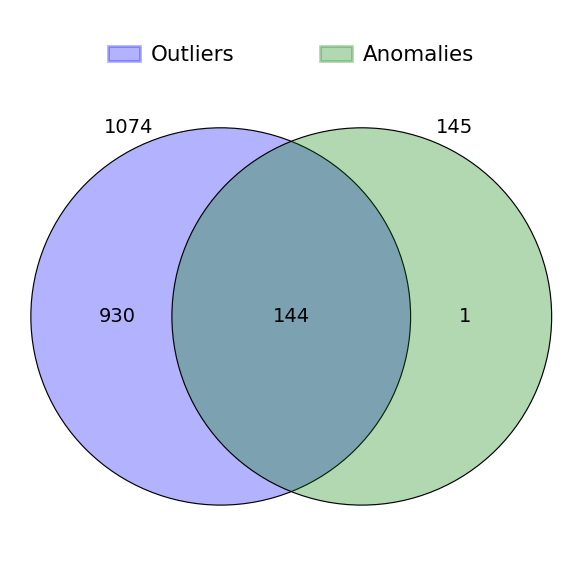

In [36]:
#dict of sets
sets = {
    # 'Inliers': set(df[(df['outlier_flag'] == 0)&(df['anomaly_flag'] == 0)].index.tolist()),
    'Outliers': set(df[df['outlier_flag'] == 1].index.tolist()),
    'Anomalies': set(df[df['anomaly_flag'] == 1].index.tolist()),
}

venny4py(sets=sets)

In [26]:
df.query("outlier_or_anomaly_flag == 'both'")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type,outlier_flag,fixed acidity_outlier,volatile acidity_outlier,citric acid_outlier,residual sugar_outlier,chlorides_outlier,free sulfur dioxide_outlier,total sulfur dioxide_outlier,density_outlier,pH_outlier,sulphates_outlier,alcohol_outlier,total_outliers,outlier_score,anomaly_flag,ecod_anomaly,lof_anomaly,iforest_anomaly,ocsvm_anomaly,autoencoder_anomaly,total_anomaly,anomaly_score,anomaly_avg_prob,outlier_or_anomaly_flag
13,7.8,0.610,0.29,1.6,0.114,9.0,29.0,0.99740,3.26,1.56,9.1,5,Red,1,0,0,0,0,0,0,0,0,0,1,0,1,0.090909,1,0,0,0,1,0,1,0.166667,0.508215,both
17,8.1,0.560,0.28,1.7,0.368,16.0,56.0,0.99680,3.11,1.28,9.3,5,Red,1,0,0,0,0,1,0,0,0,0,1,0,2,0.181818,1,0,0,0,1,0,1,0.166667,0.433201,both
19,7.9,0.320,0.51,1.8,0.341,17.0,56.0,0.99690,3.04,1.08,9.2,6,Red,1,0,0,0,0,1,0,0,0,0,1,0,2,0.181818,1,0,0,0,1,0,1,0.166667,0.443534,both
42,7.5,0.490,0.20,2.6,0.332,8.0,14.0,0.99680,3.21,0.90,10.5,6,Red,1,0,0,0,0,1,0,0,0,0,0,0,1,0.090909,1,0,0,0,1,0,1,0.166667,0.428668,both
81,7.8,0.430,0.70,1.9,0.464,22.0,67.0,0.99740,3.13,1.28,9.4,5,Red,1,0,0,0,0,1,0,0,0,0,1,0,2,0.181818,1,0,0,0,1,0,1,0.166667,0.534320,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6096,6.3,0.290,0.30,8.1,0.212,60.0,150.0,0.99580,3.10,0.40,9.3,5,White,1,0,0,0,0,1,0,0,0,0,0,0,1,0.090909,1,0,0,0,1,0,1,0.166667,0.336585,both
6297,7.0,0.270,0.74,1.3,0.173,34.0,121.0,0.99334,3.04,0.46,9.2,6,White,1,0,0,1,0,1,0,0,0,0,0,0,2,0.181818,1,0,0,0,1,0,1,0.166667,0.349865,both
6344,6.1,0.260,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,White,1,0,0,0,0,0,1,1,0,0,0,0,2,0.181818,1,0,0,0,1,0,1,0.166667,0.623694,both
6391,4.7,0.785,0.00,3.4,0.036,23.0,134.0,0.98981,3.53,0.92,13.8,6,White,1,0,1,1,0,0,0,0,0,0,1,0,3,0.272727,1,0,0,1,1,0,2,0.333333,0.556167,both


In [27]:
df.query("outlier_or_anomaly_flag == 'anomaly'")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type,outlier_flag,fixed acidity_outlier,volatile acidity_outlier,citric acid_outlier,residual sugar_outlier,chlorides_outlier,free sulfur dioxide_outlier,total sulfur dioxide_outlier,density_outlier,pH_outlier,sulphates_outlier,alcohol_outlier,total_outliers,outlier_score,anomaly_flag,ecod_anomaly,lof_anomaly,iforest_anomaly,ocsvm_anomaly,autoencoder_anomaly,total_anomaly,anomaly_score,anomaly_avg_prob,outlier_or_anomaly_flag
94,5.0,1.02,0.04,1.4,0.045,41.0,85.0,0.9938,3.75,0.48,10.5,4,Red,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,1,0,0,0,0,1,0.166667,0.672159,anomaly


# Box and Swarm Plots

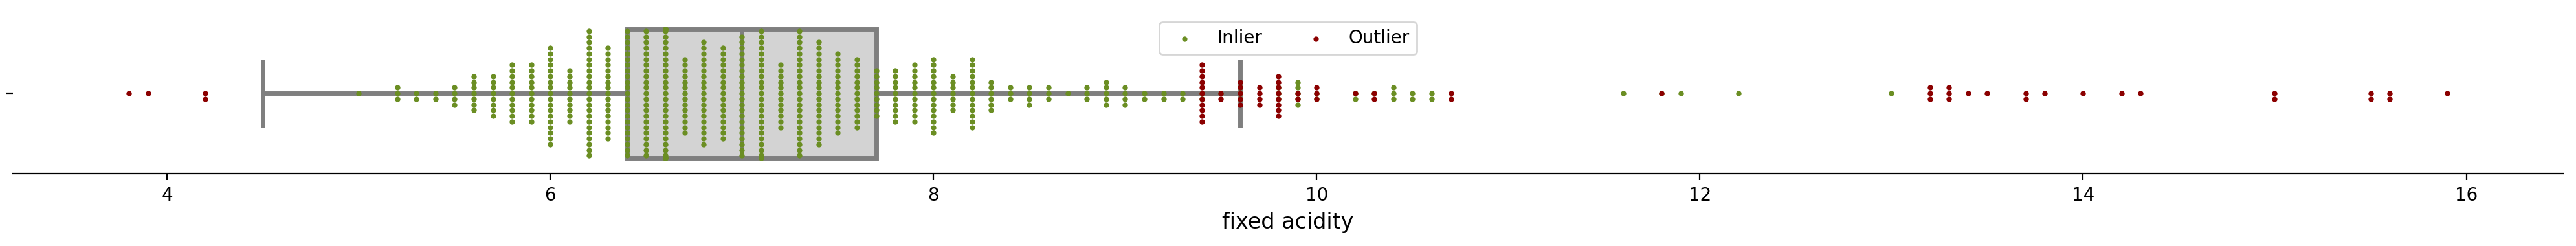

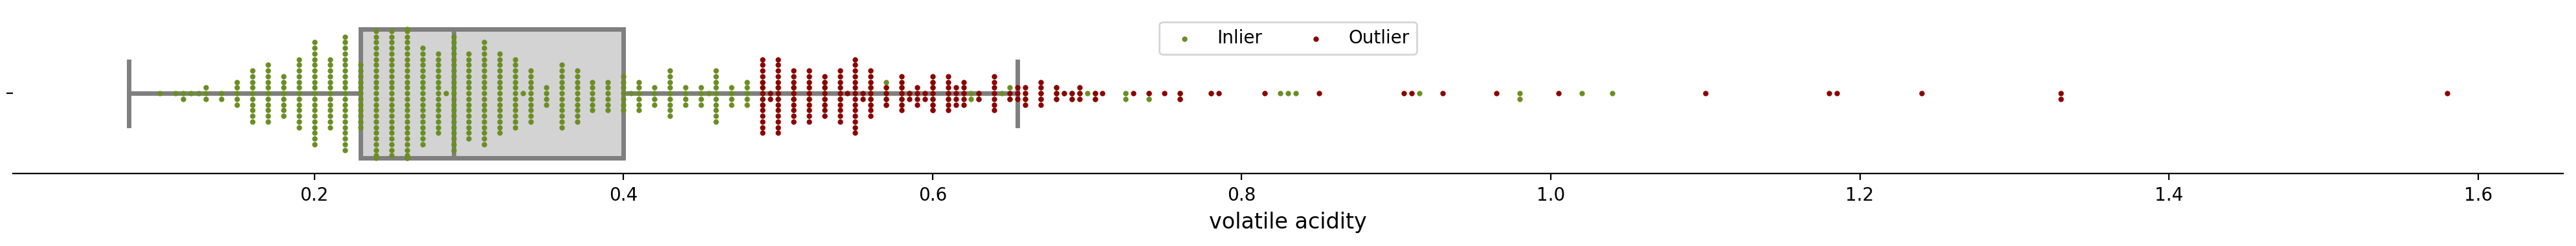

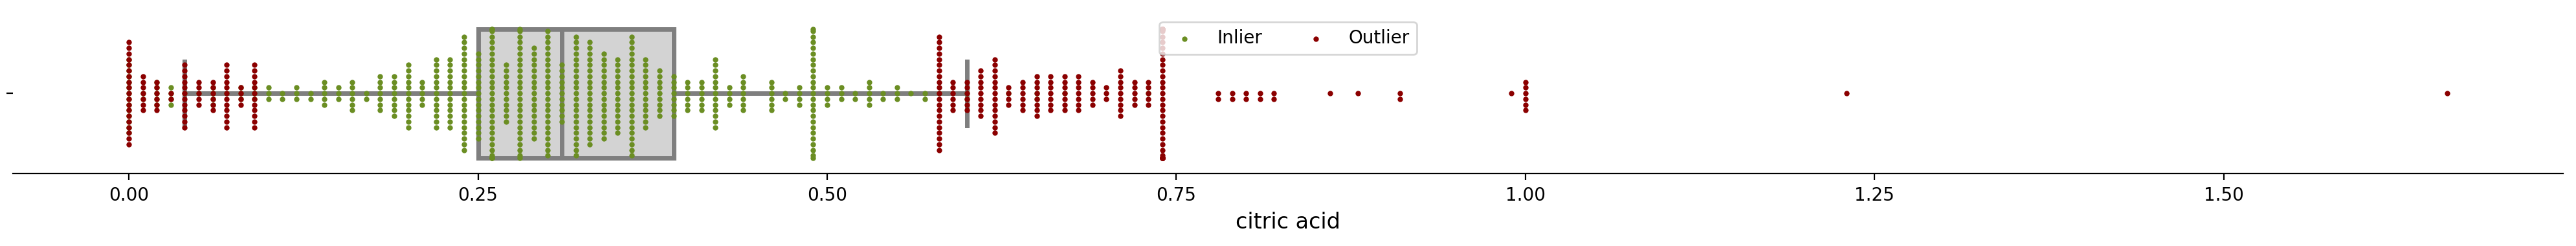

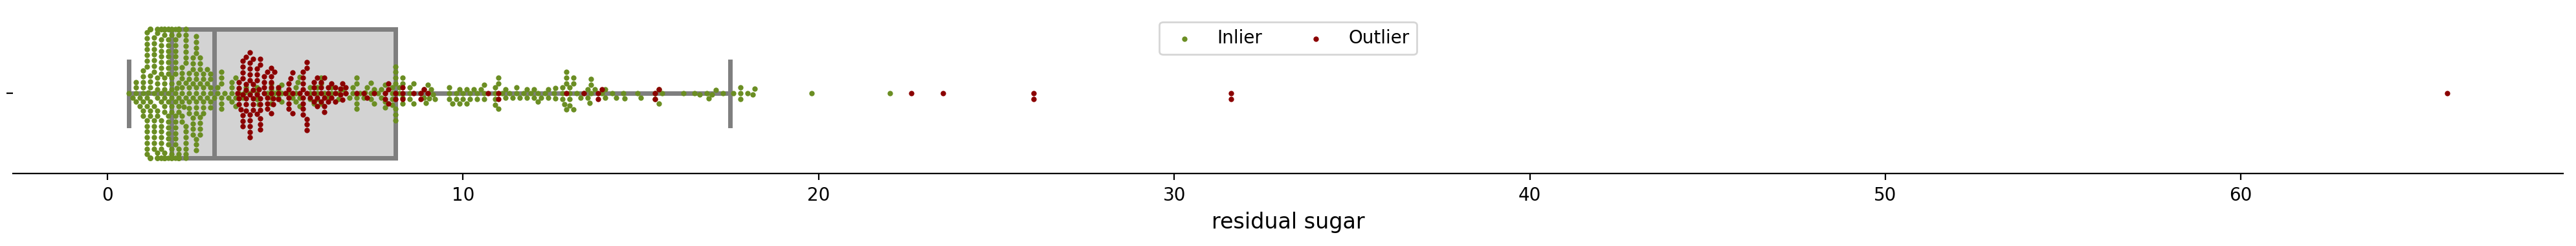

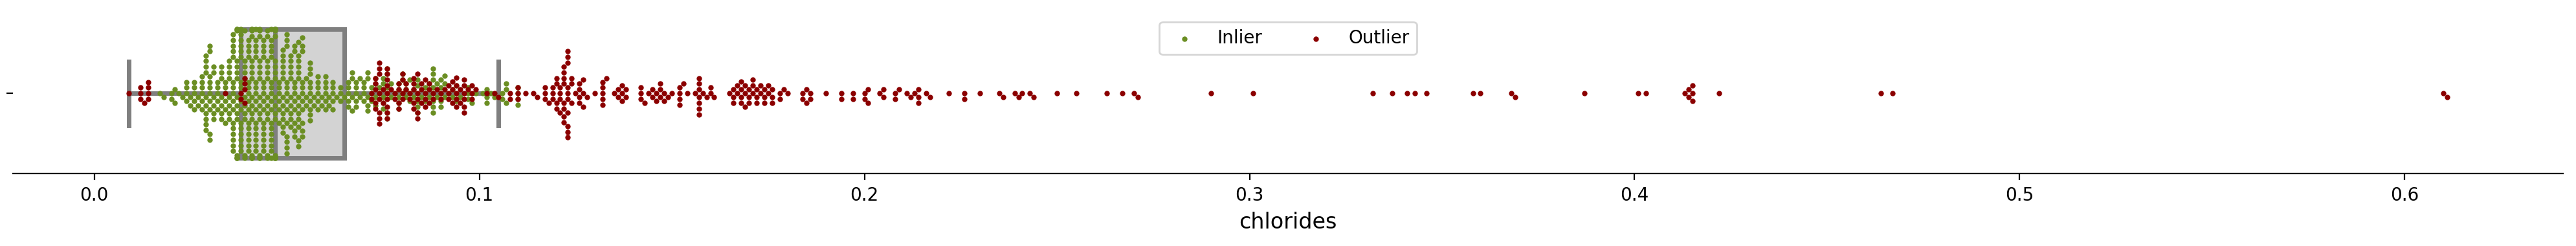

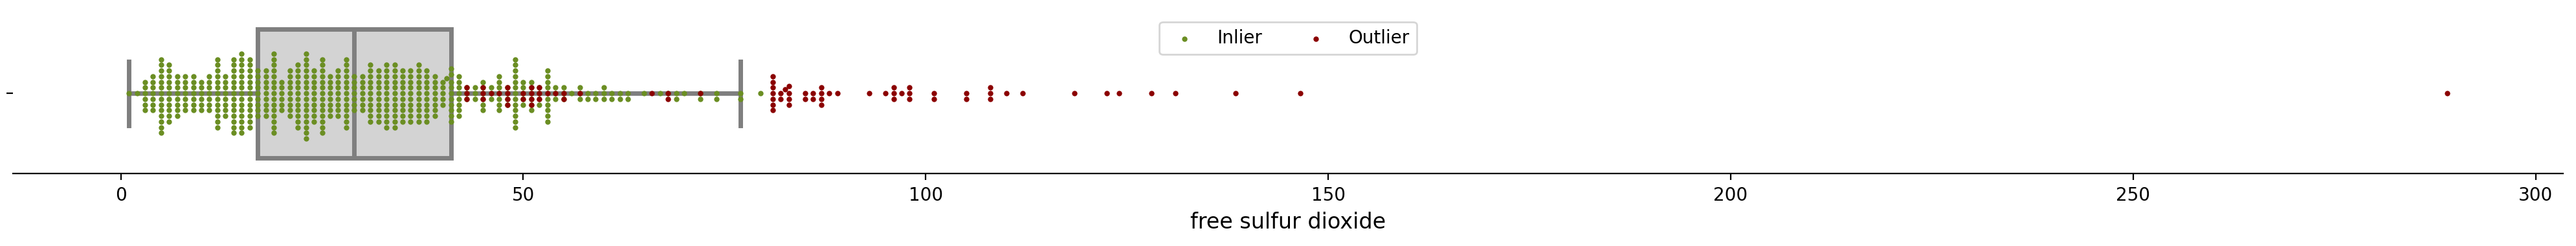

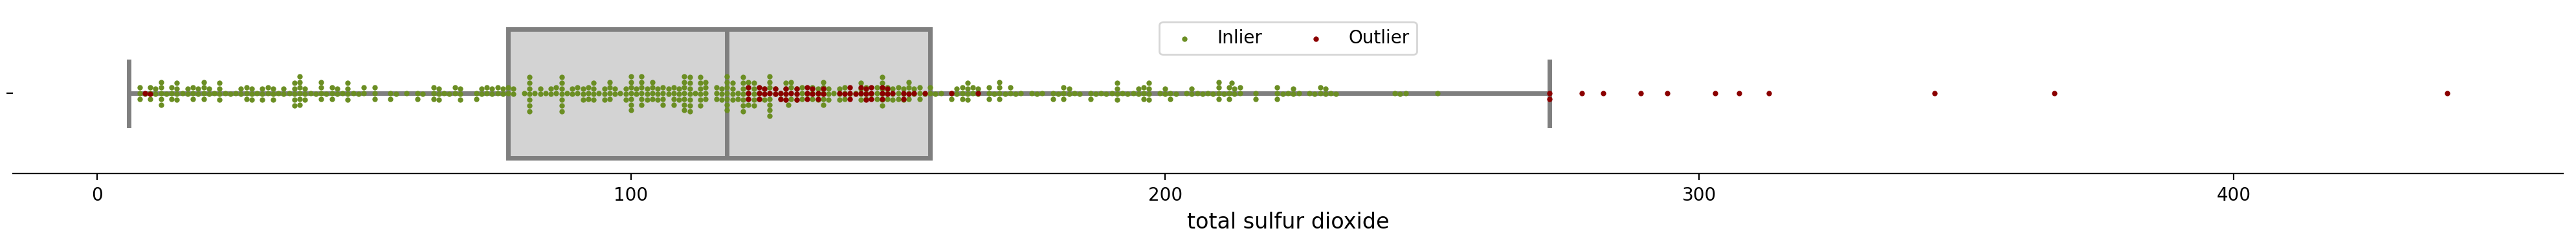

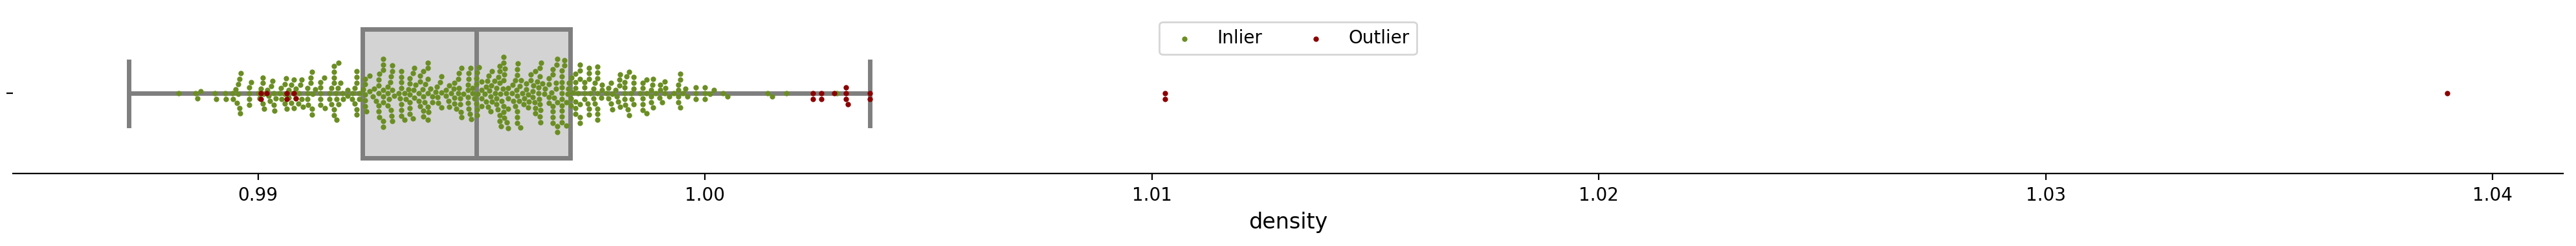

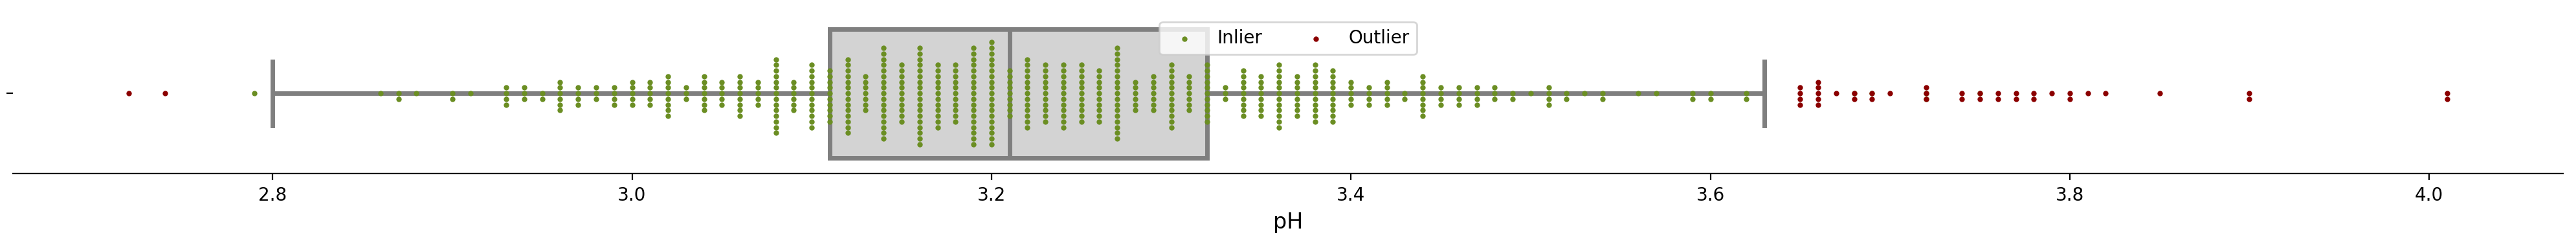

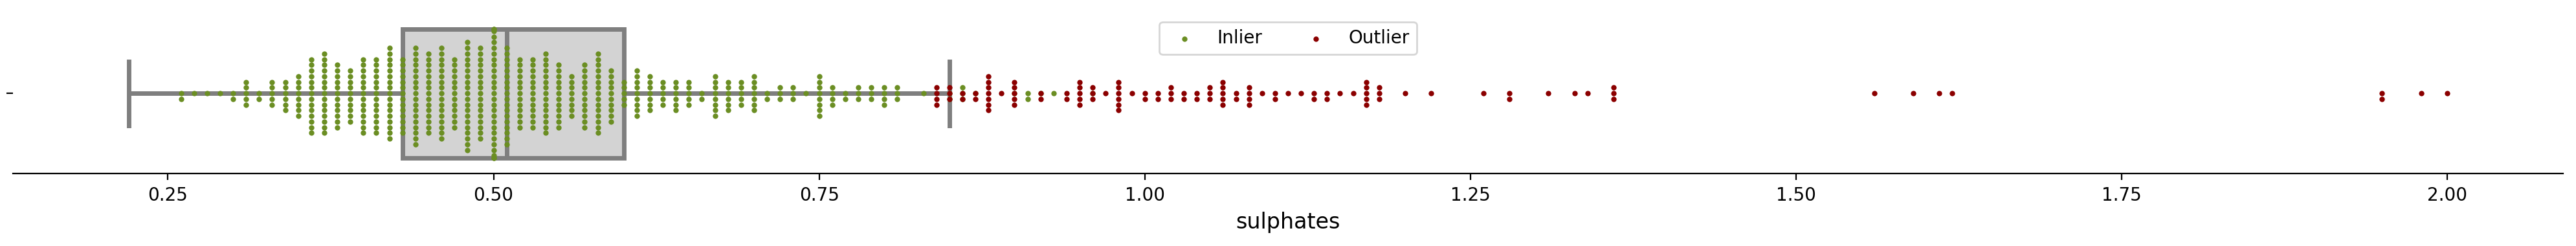

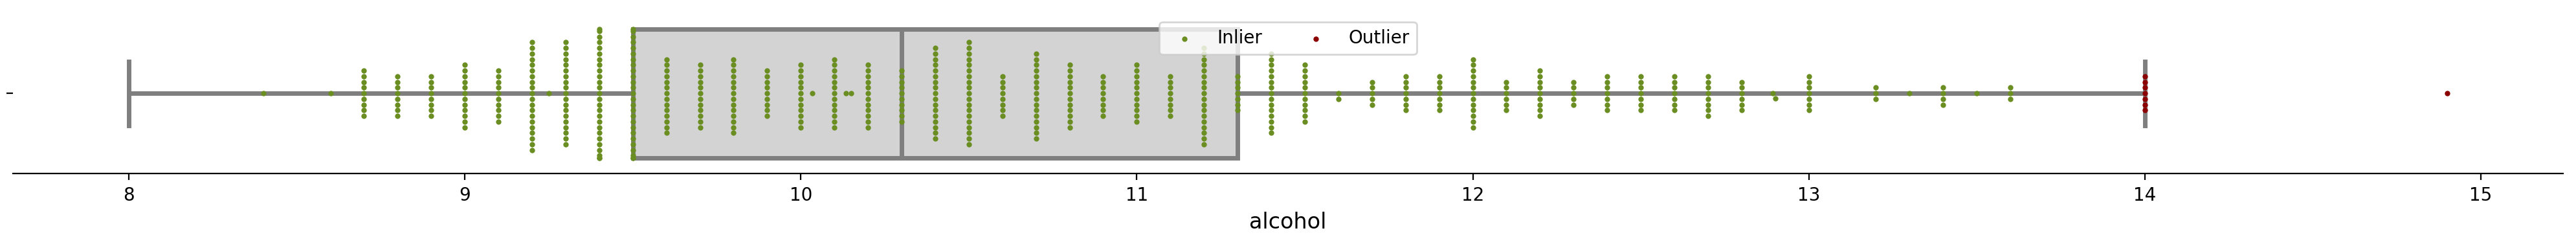

In [28]:
for metric in col_list:
    plt.figure(figsize=(20, 2))

    # Separate inliers and outliers for the current metric
    inliers = df[df[f'{metric}_outlier'] == 0]
    outliers = df[df[f'{metric}_outlier'] == 1]

    sample_size = 500

    # Sample inliers if there are more than N
    if len(inliers) > sample_size:
        sampled_inliers = inliers.sample(n=sample_size, random_state=42) # Using a fixed random_state for reproducibility
    else:
        sampled_inliers = inliers # If fewer than 1000, use all of them

    # Plot sampled inliers
    sns.swarmplot(x=f'{metric}', data=sampled_inliers, color=color_1, size=3, label='Inlier', ax=plt.gca()) # ax=plt.gca() ensures it plots on the current figure

    # Plot the boxplot (this uses the full data, which is fine as it's a summary)
    sns.boxplot(x=f'{metric}', data=df, orient='h', color='lightgrey', showfliers=False, linewidth=2.5, ax=plt.gca())

    # Plot all outliers
    sns.swarmplot(x=f'{metric}', data=outliers, color=color_2, size=3, label='Outlier', ax=plt.gca())

    plt.legend(loc='upper center', ncols=3)
    plt.xlabel(f'{metric}', size=12)
    # plt.title(f'{metric} Outliers', size=16) # Uncomment if you want titles
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

### Grouped Swarm Plots

Generating plots for group: wine type: Red (N=1599 rows)


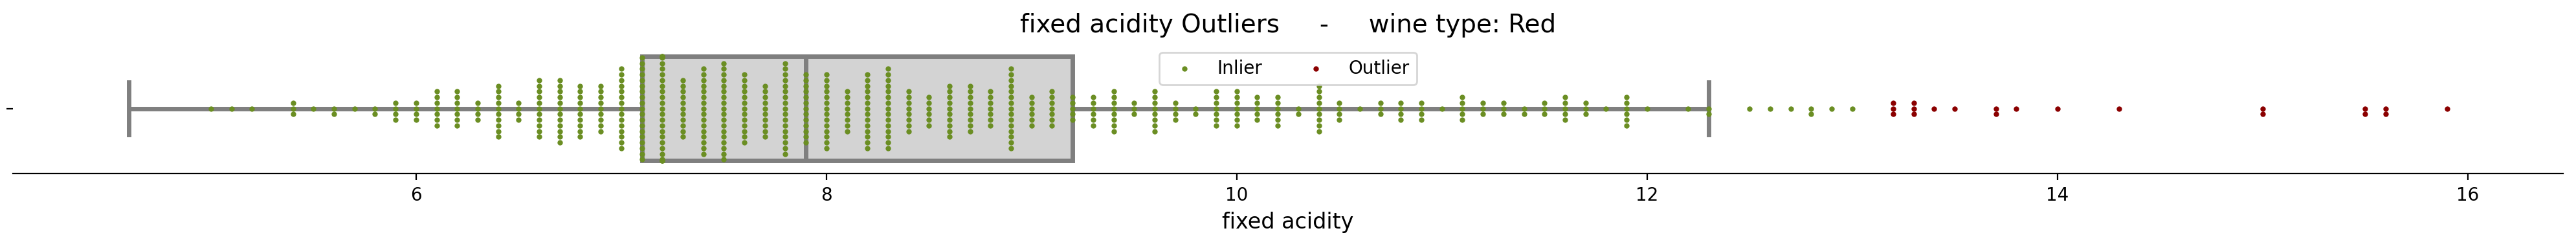

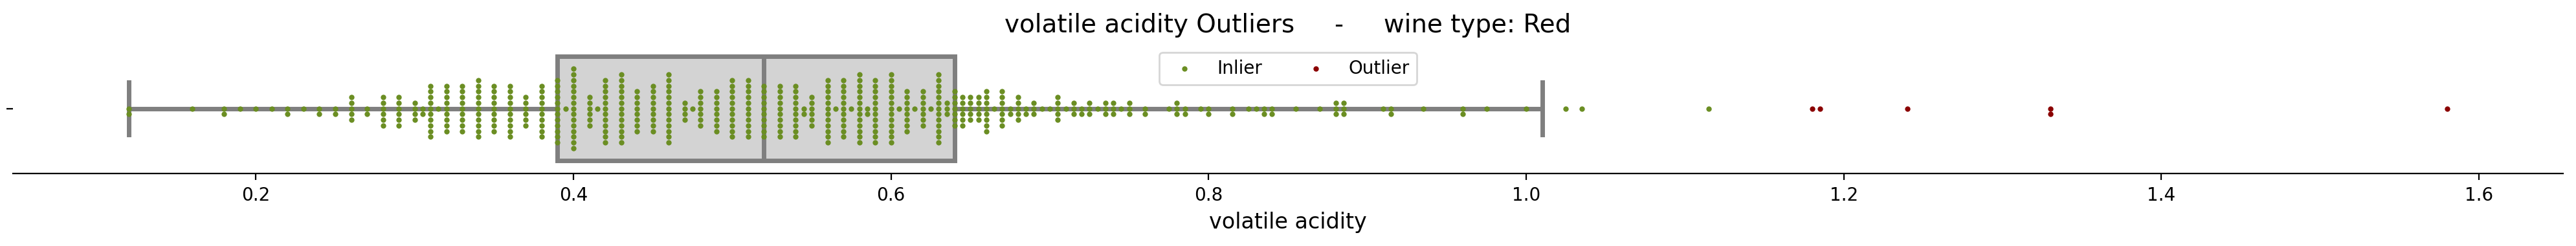

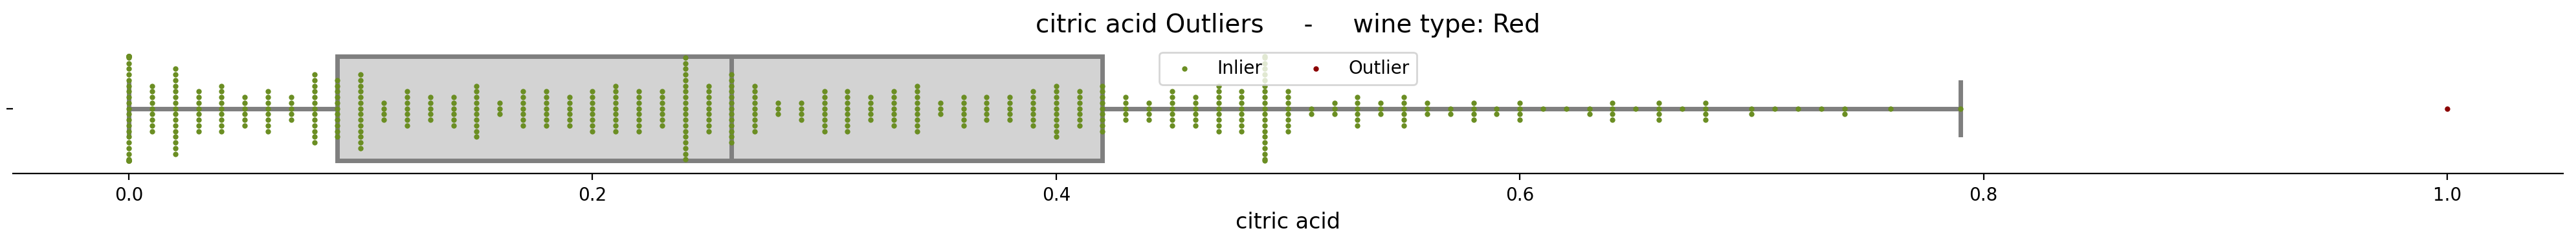

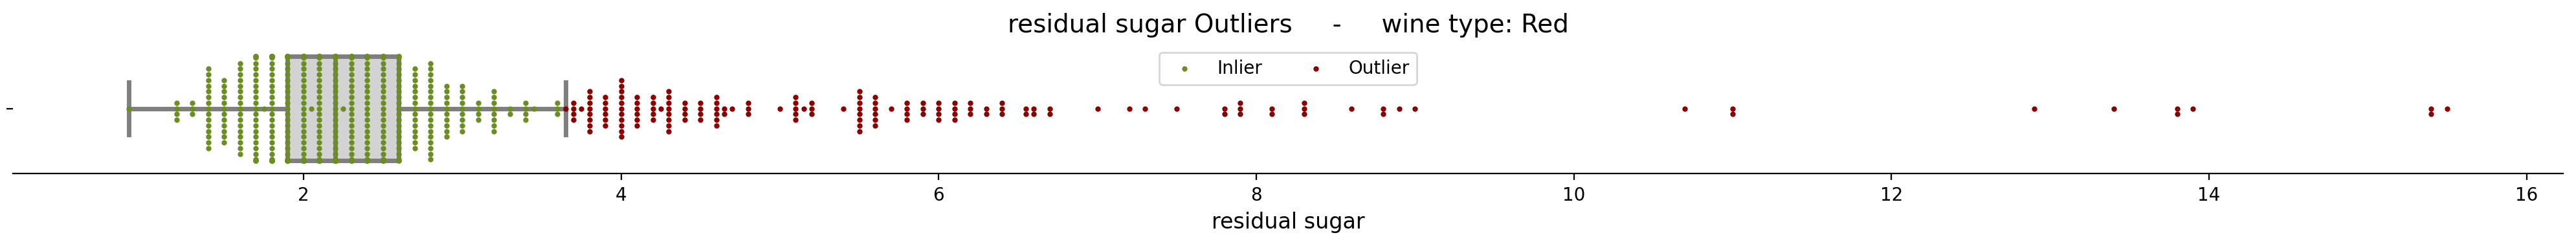

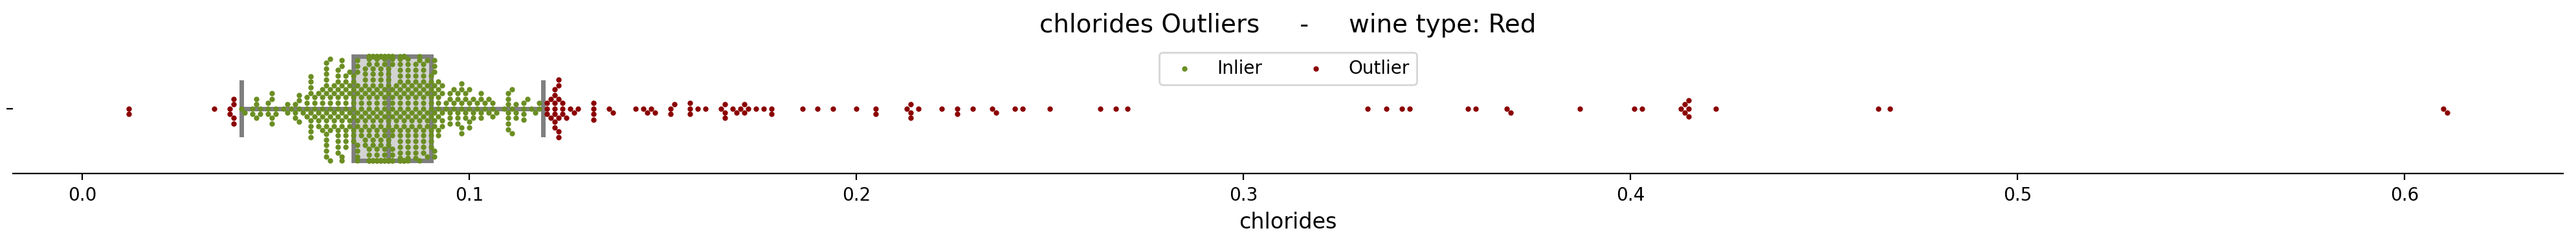

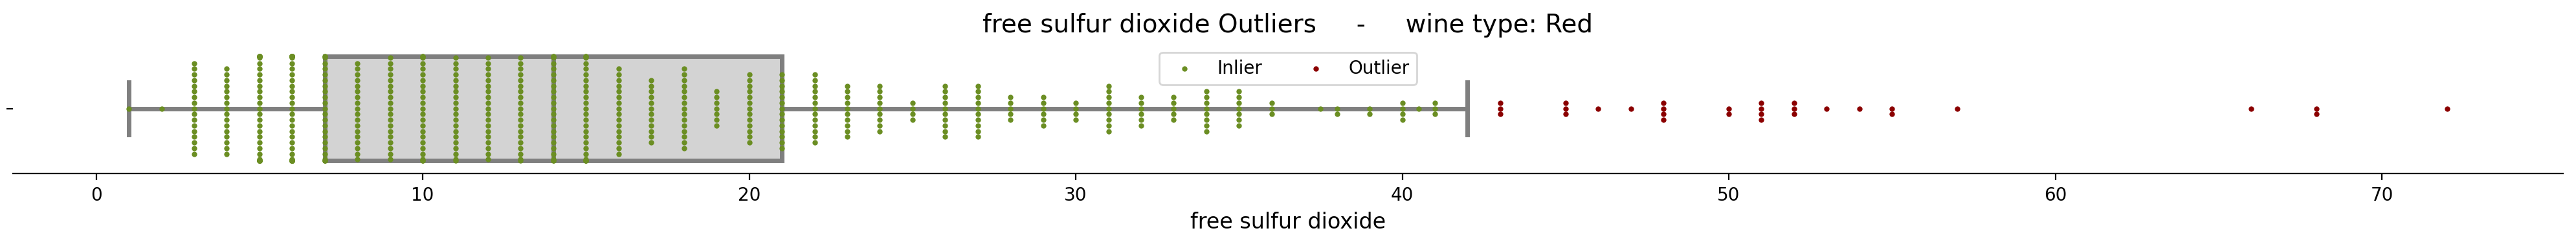

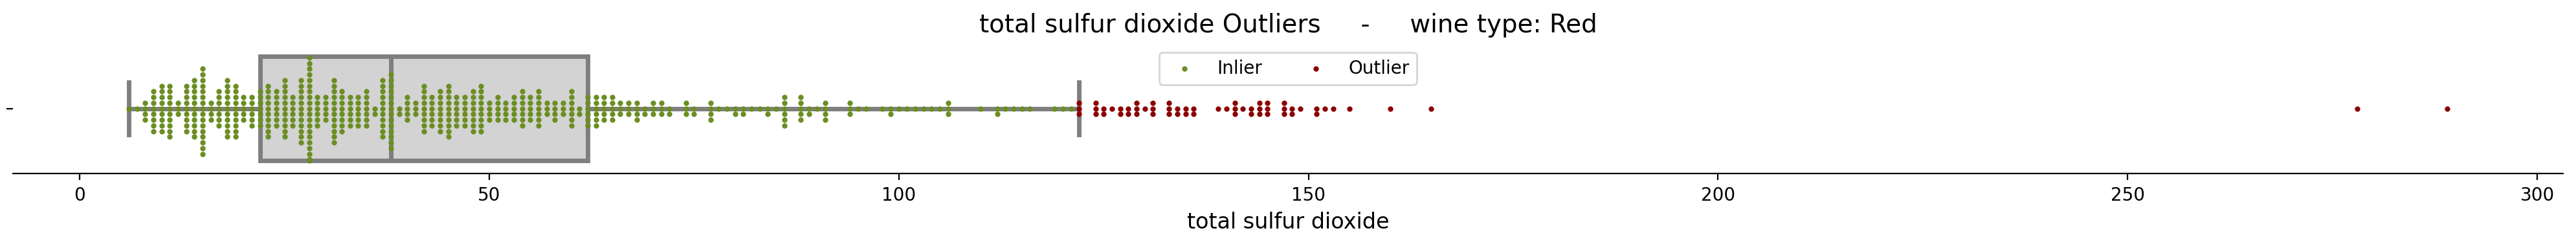

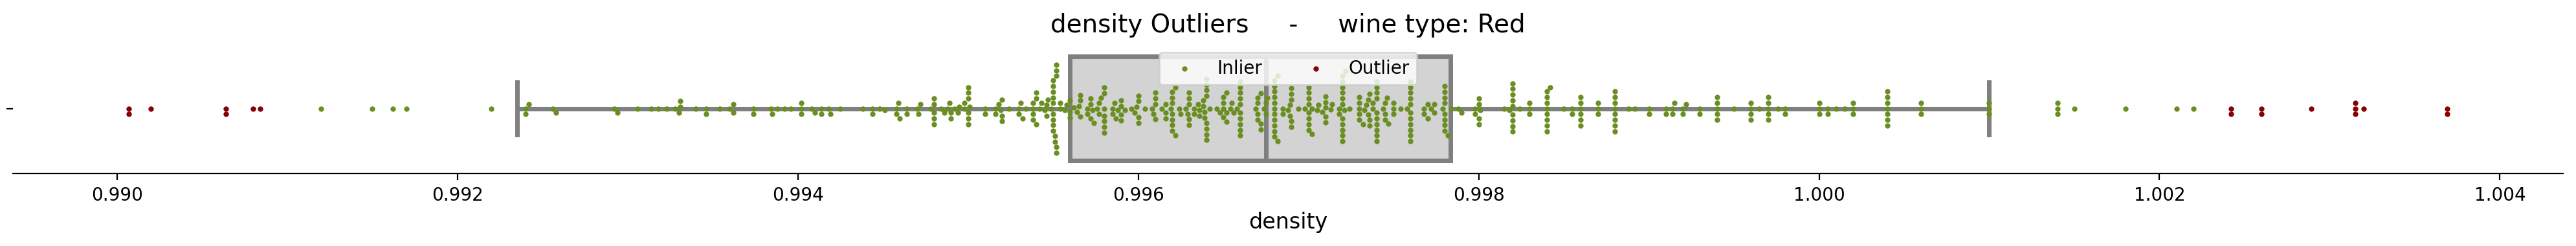

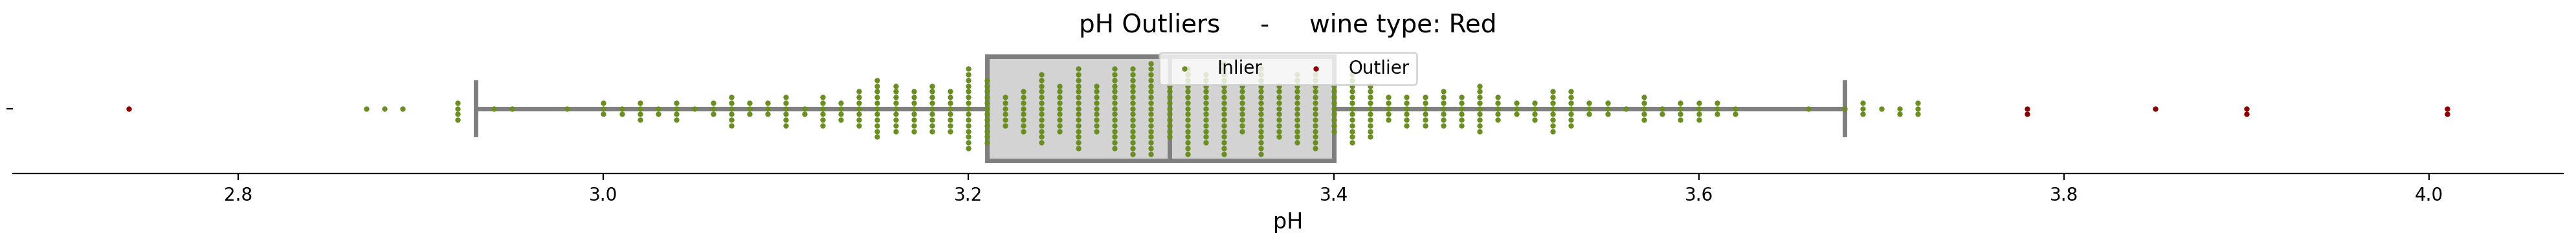

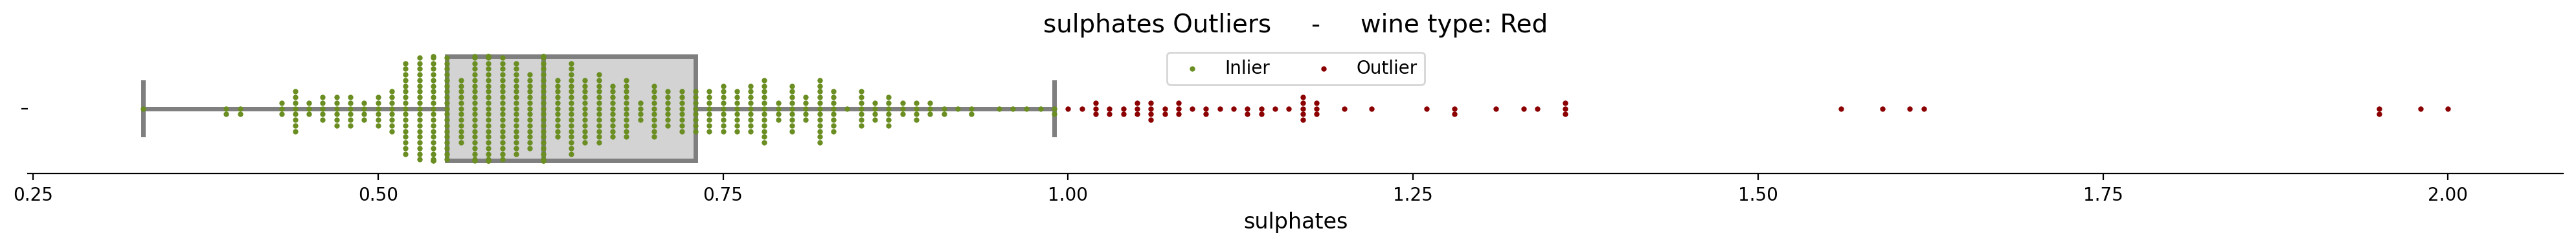

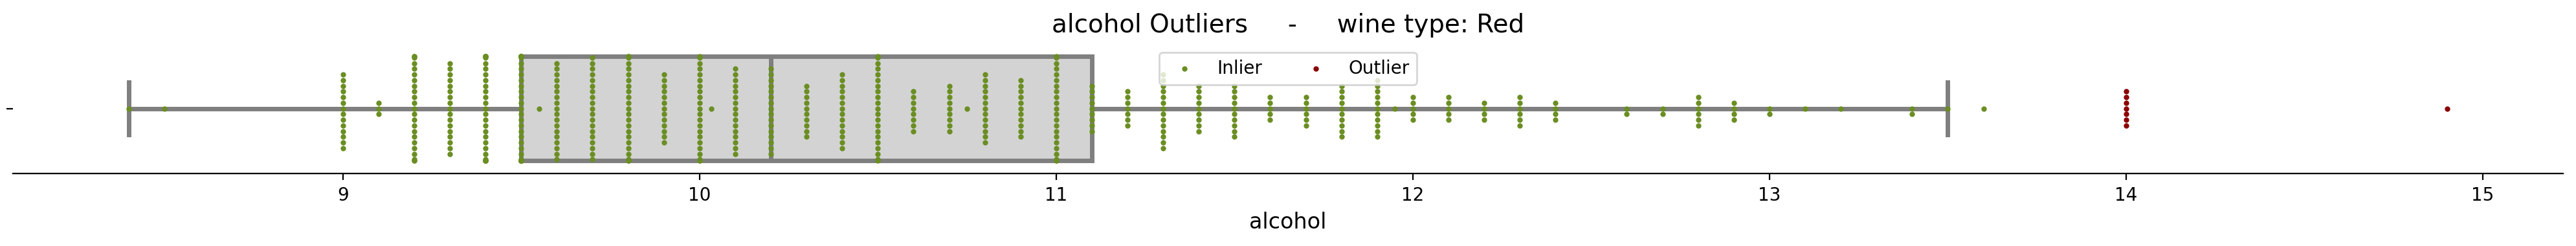

Generating plots for group: wine type: White (N=4898 rows)


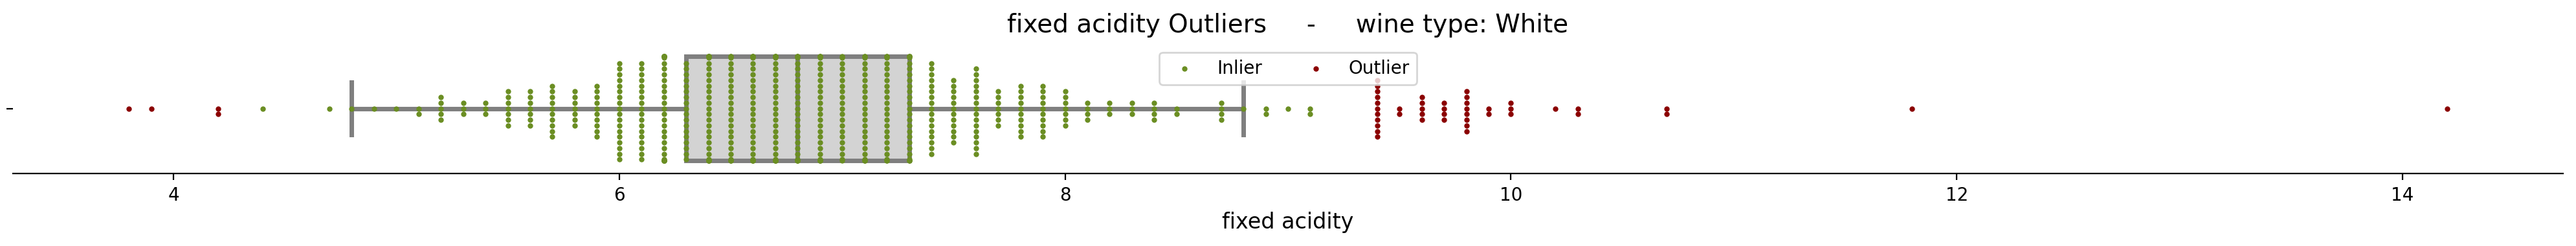

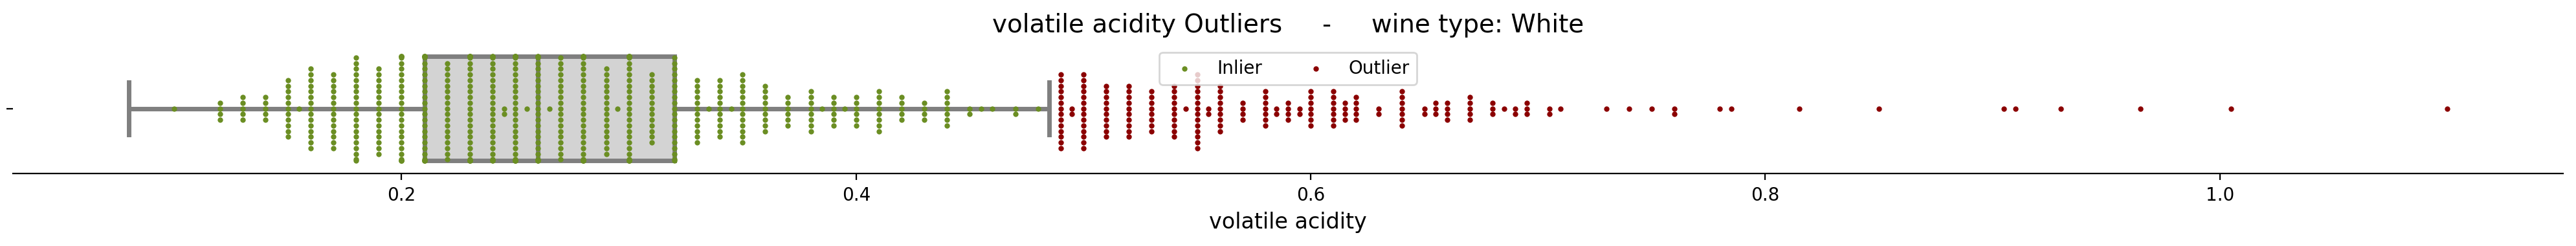

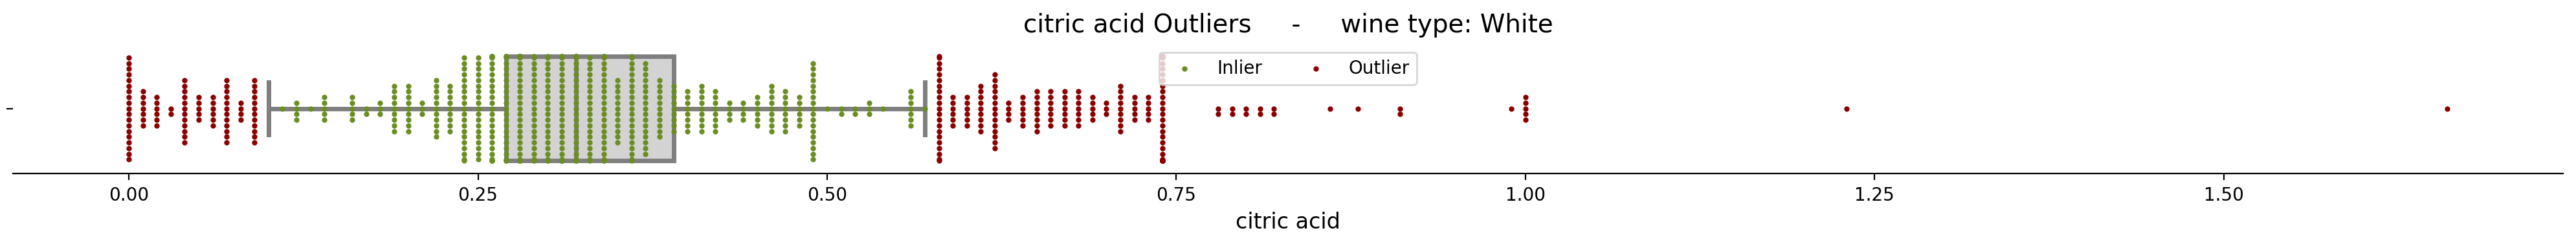

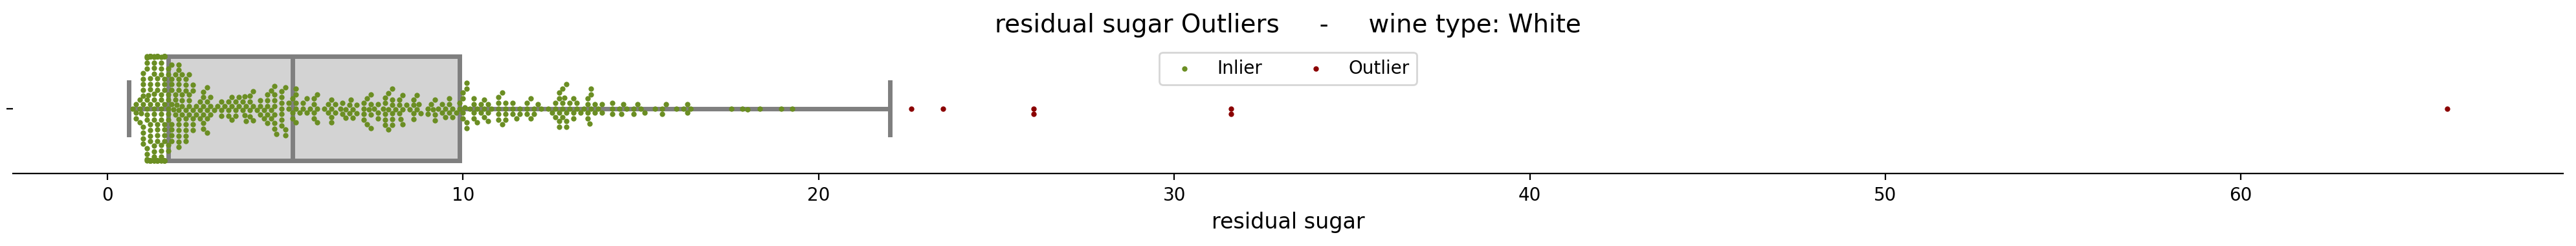

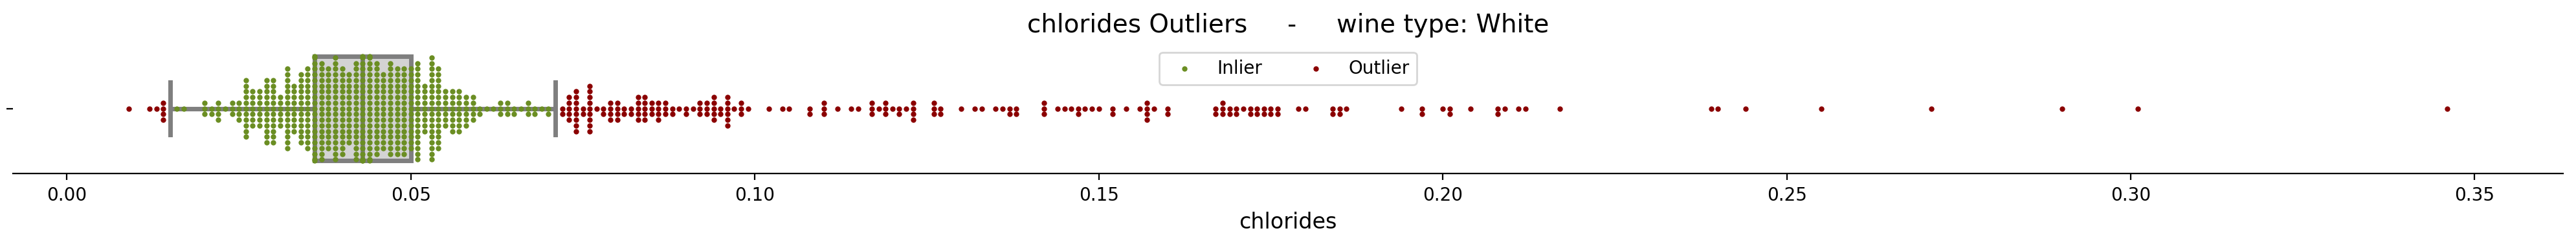

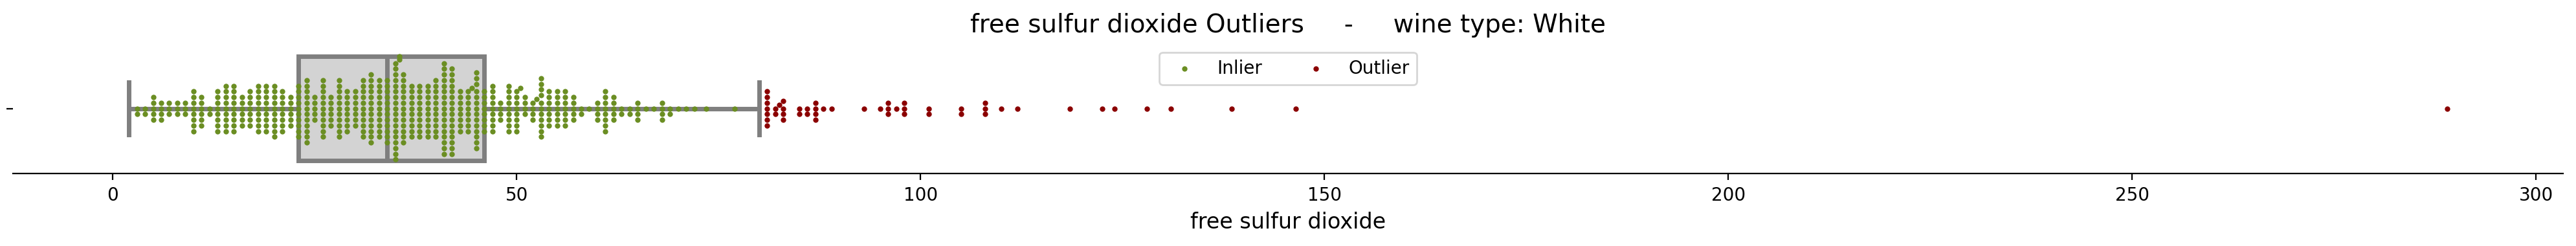

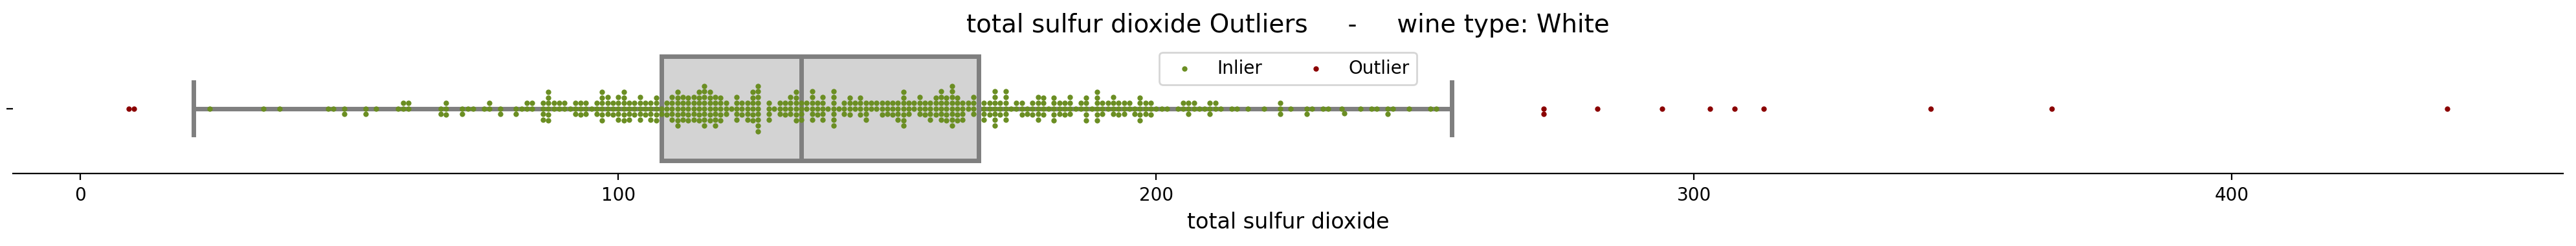

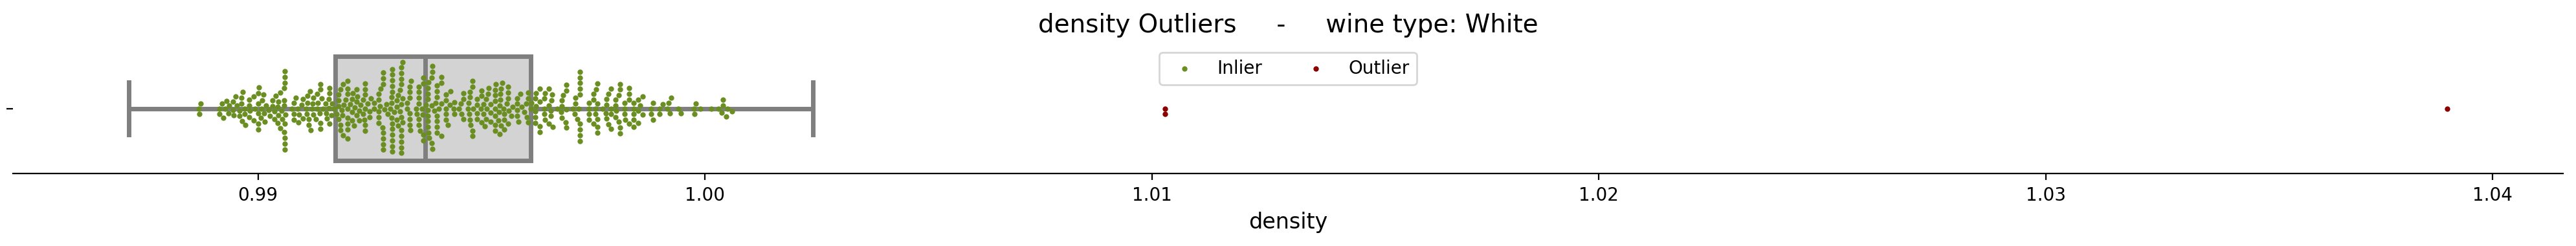

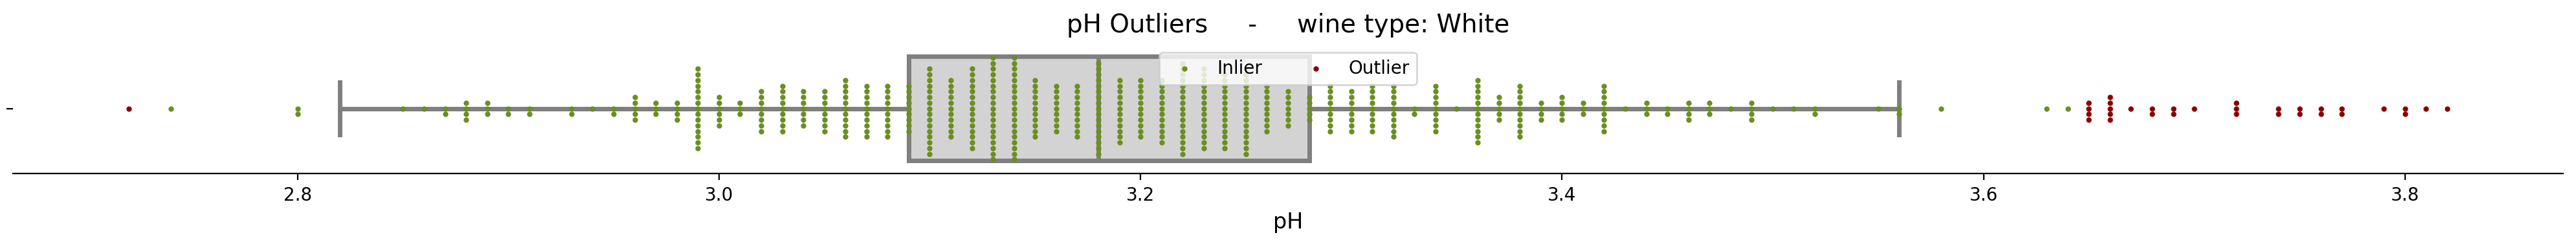

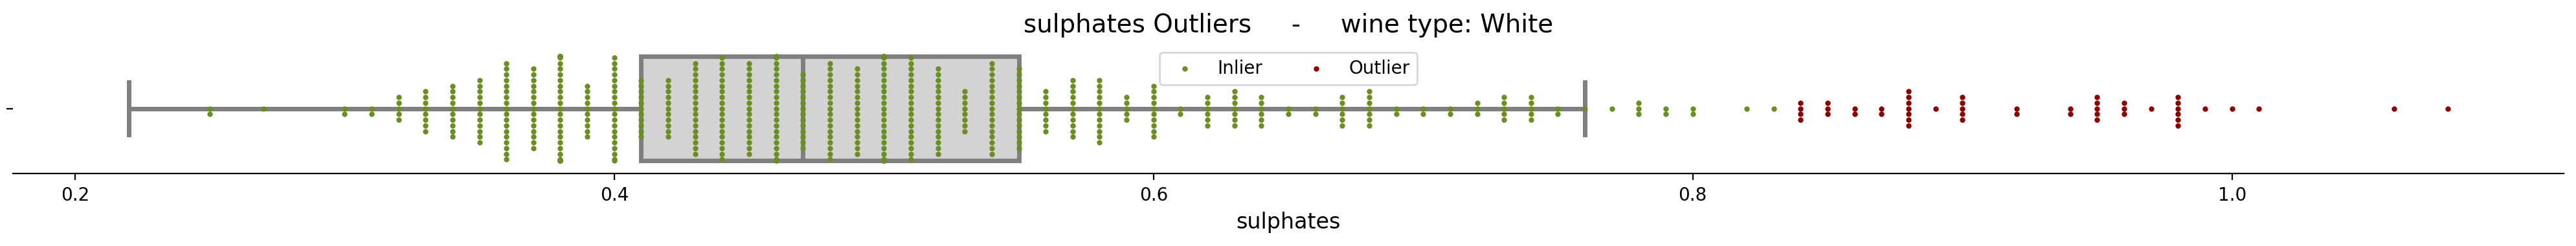

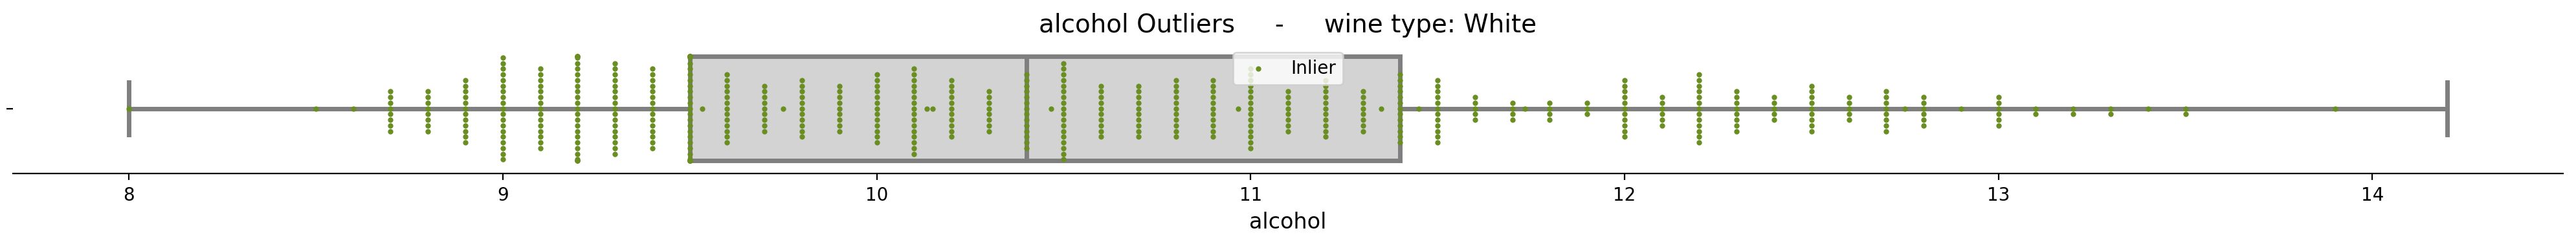

In [35]:
# The sample size for inliers, when there are too many points the charts have issues
sample_size = 500 

# Determine the groups to iterate over
if not group_by_cols:
    # If group_by_cols is empty, treat the entire DataFrame as one 'global' group
    groups_to_plot = [("Global", df)]
else:
    # Get an iterable of (group_name, group_dataframe) tuples
    groups_to_plot = []
    for name, group_df in df.groupby(group_by_cols):
        # Ensure 'name' is a tuple even for single grouping column
        group_name_tuple = name if isinstance(name, tuple) else (name,)
        groups_to_plot.append((group_name_tuple, group_df))

# Outer loop: Iterate through each group
for group_name_tuple, current_group_df in groups_to_plot:
    # Create a string for the group title
    if group_name_tuple == ("Global",):
        group_title_str = "Global Data"
    else:
        # Join group column names with their values for a descriptive title
        group_title_str = ", ".join([f"{col}: {val}" for col, val in zip(group_by_cols, group_name_tuple)])

    print(f"Generating plots for group: {group_title_str} (N={len(current_group_df)} rows)")

    # Inner loop: Iterate through each metric within the current group
    for metric in col_list:
        outlier_col_name = f'{metric}_outlier'

        # Create a new figure for each plot
        plt.figure(figsize=(20, 2))

        # Separate inliers and outliers for the current metric WITHIN THIS GROUP
        inliers = current_group_df[current_group_df[outlier_col_name] == 0]
        outliers = current_group_df[current_group_df[outlier_col_name] == 1]

        # Sample inliers
        sampled_inliers = inliers.sample(n=sample_size, random_state=42)

        # Plot sampled inliers 
        sns.swarmplot(x=f'{metric}', data=sampled_inliers, color=color_1, size=3, label='Inlier', ax=plt.gca())

        # Plot the boxplot (this uses the full current group data)
        sns.boxplot(x=f'{metric}', data=current_group_df, orient='h', color='lightgrey', showfliers=False, linewidth=2.5, ax=plt.gca())

        # Plot all outliers
        sns.swarmplot(x=f'{metric}', data=outliers, color=color_2, size=3, label='Outlier', ax=plt.gca())

        plt.legend(loc='upper center', ncols=3)
        plt.xlabel(f'{metric}', size=12)
        # Update the title to include the current group information
        plt.title(f'{metric} Outliers     -     {group_title_str}', size=14)
        plt.tight_layout() 
        plt.show()

### Manual Corrections

In [ ]:
df['fixed acidity' + '_outlier'] = np.where( df['fixed acidity'] >= 14 ,
                                                    1, 
                                                    df['fixed acidity' + '_outlier'])


df['volatile acidity' + '_outlier'] = np.where( df['volatile acidity'] >= 13 ,
                                                    1, 
                                                    df['volatile acidity' + '_outlier'])